<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import Imputer,StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest,f_classif,chi2,RFECV,RFE
from sklearn.linear_model import LogisticRegression,LinearRegression,LassoCV,Lasso,ElasticNetCV,ElasticNet
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import classification_report,r2_score

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
# Load the data
house = pd.read_csv('./housing.csv')

In [4]:
house.shape

(1460, 81)

In [5]:
house.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'Pav

In [6]:
def df_infor(x):
    x.columns = x.columns.str.strip().str.lower().str.replace('\s+','_').str.replace('-','')
    df_isnull = pd.DataFrame(x.isnull().sum(),columns=['null_count'])
    df_iszero = pd.DataFrame((x == 0).sum(),columns=['zero_count'])
    df_type = pd.DataFrame(x.dtypes, columns=['d_types'])
    return pd.DataFrame(df_type.join(df_isnull).join(df_iszero))

In [7]:
a = df_infor(house)
display (a.loc[a.null_count>0])

,d_types,null_count,zero_count
lotfrontage,float64,259,0
alley,object,1369,0
masvnrtype,object,8,0
masvnrarea,float64,8,861
bsmtqual,object,37,0
bsmtcond,object,37,0
bsmtexposure,object,38,0
bsmtfintype1,object,37,0
bsmtfintype2,object,38,0
electrical,object,1,0


### Shaun's comment on null values:
<font color='red'>lotfrontage:</font> 
    represent measurement. Might mean 0 street length or missing information. 
        <b> Convert null values by imputation</b>
<br><font color='red'>alley:</font>
    represent no alley access. 
        <b> Convert null to zero. Binarize this attribute </b>
<br><font color='red'>masvnrtype:</font>
    represent no masonry type.
        <b> Convert null to zero. Binarize this attribute </b>
<br><font color='red'>masvnrarea:</font>
    represent no masonry measurement. null and zero values present.
        <b> Convert null by zero. </b>
<br><font color='red'>bsmtqual/ bsmtcond/ bsmtexposure/ bsmtfintype1/ bsmtfintype2:</font>
    represent ratings. (ordinal variable)
        <b> ????? </b>
<br><font color='red'>fireplacequ:</font>
    represent no fireplace.
        <b> Convert null to zero. Binarize this attribute </b>
<br><font color='red'>garagetype/ garageyrblt/ garagefinish/ garagequal/ garagecond:</font>
    represent no garage.
        <b> Convert null to zero. Binarize this attribute </b>
<br><font color='red'>poolqc:</font>
    represent no pool present.
        <b> Convert null to zero. Binarize this attribute </b> 
<br><font color='red'>fence:</font>
    represent no fence present.
        <b> Convert null to zero. Binarize this attribute </b>
<br><font color='red'>miscfeature:</font>
    represent no miscfeature present.
        <b> Convert null to zero. Binarize this attribute </b> 

#### Impute values for null values in imputation:

In [8]:
# reshape array before imputation
temp = (house.lotfrontage.values).reshape(-1,1)

imputer = Imputer()
lotfrontage_impute = pd.DataFrame(imputer.fit_transform(temp))

In [9]:
# update lotfrontage with imputed values
lotfrontage_impute.rename(columns={0:'lotfrontage'},inplace=True)
house.update(lotfrontage_impute)

#### Split dataset into residential and non-residential

In [10]:
residential = house.loc[house.mszoning.isin(['RH','RL','RP','RM','FV'])].copy()
non_residential = house.loc[~house.mszoning.isin(['RH','RL','RP','RM','FV'])].copy()

In [11]:
residential.columns

Index([u'id', u'mssubclass', u'mszoning', u'lotfrontage', u'lotarea',
       u'street', u'alley', u'lotshape', u'landcontour', u'utilities',
       u'lotconfig', u'landslope', u'neighborhood', u'condition1',
       u'condition2', u'bldgtype', u'housestyle', u'overallqual',
       u'overallcond', u'yearbuilt', u'yearremodadd', u'roofstyle',
       u'roofmatl', u'exterior1st', u'exterior2nd', u'masvnrtype',
       u'masvnrarea', u'exterqual', u'extercond', u'foundation', u'bsmtqual',
       u'bsmtcond', u'bsmtexposure', u'bsmtfintype1', u'bsmtfinsf1',
       u'bsmtfintype2', u'bsmtfinsf2', u'bsmtunfsf', u'totalbsmtsf',
       u'heating', u'heatingqc', u'centralair', u'electrical', u'1stflrsf',
       u'2ndflrsf', u'lowqualfinsf', u'grlivarea', u'bsmtfullbath',
       u'bsmthalfbath', u'fullbath', u'halfbath', u'bedroomabvgr',
       u'kitchenabvgr', u'kitchenqual', u'totrmsabvgrd', u'functional',
       u'fireplaces', u'fireplacequ', u'garagetype', u'garageyrblt',
       u'garagefinish',

### Residential Dataset EDA

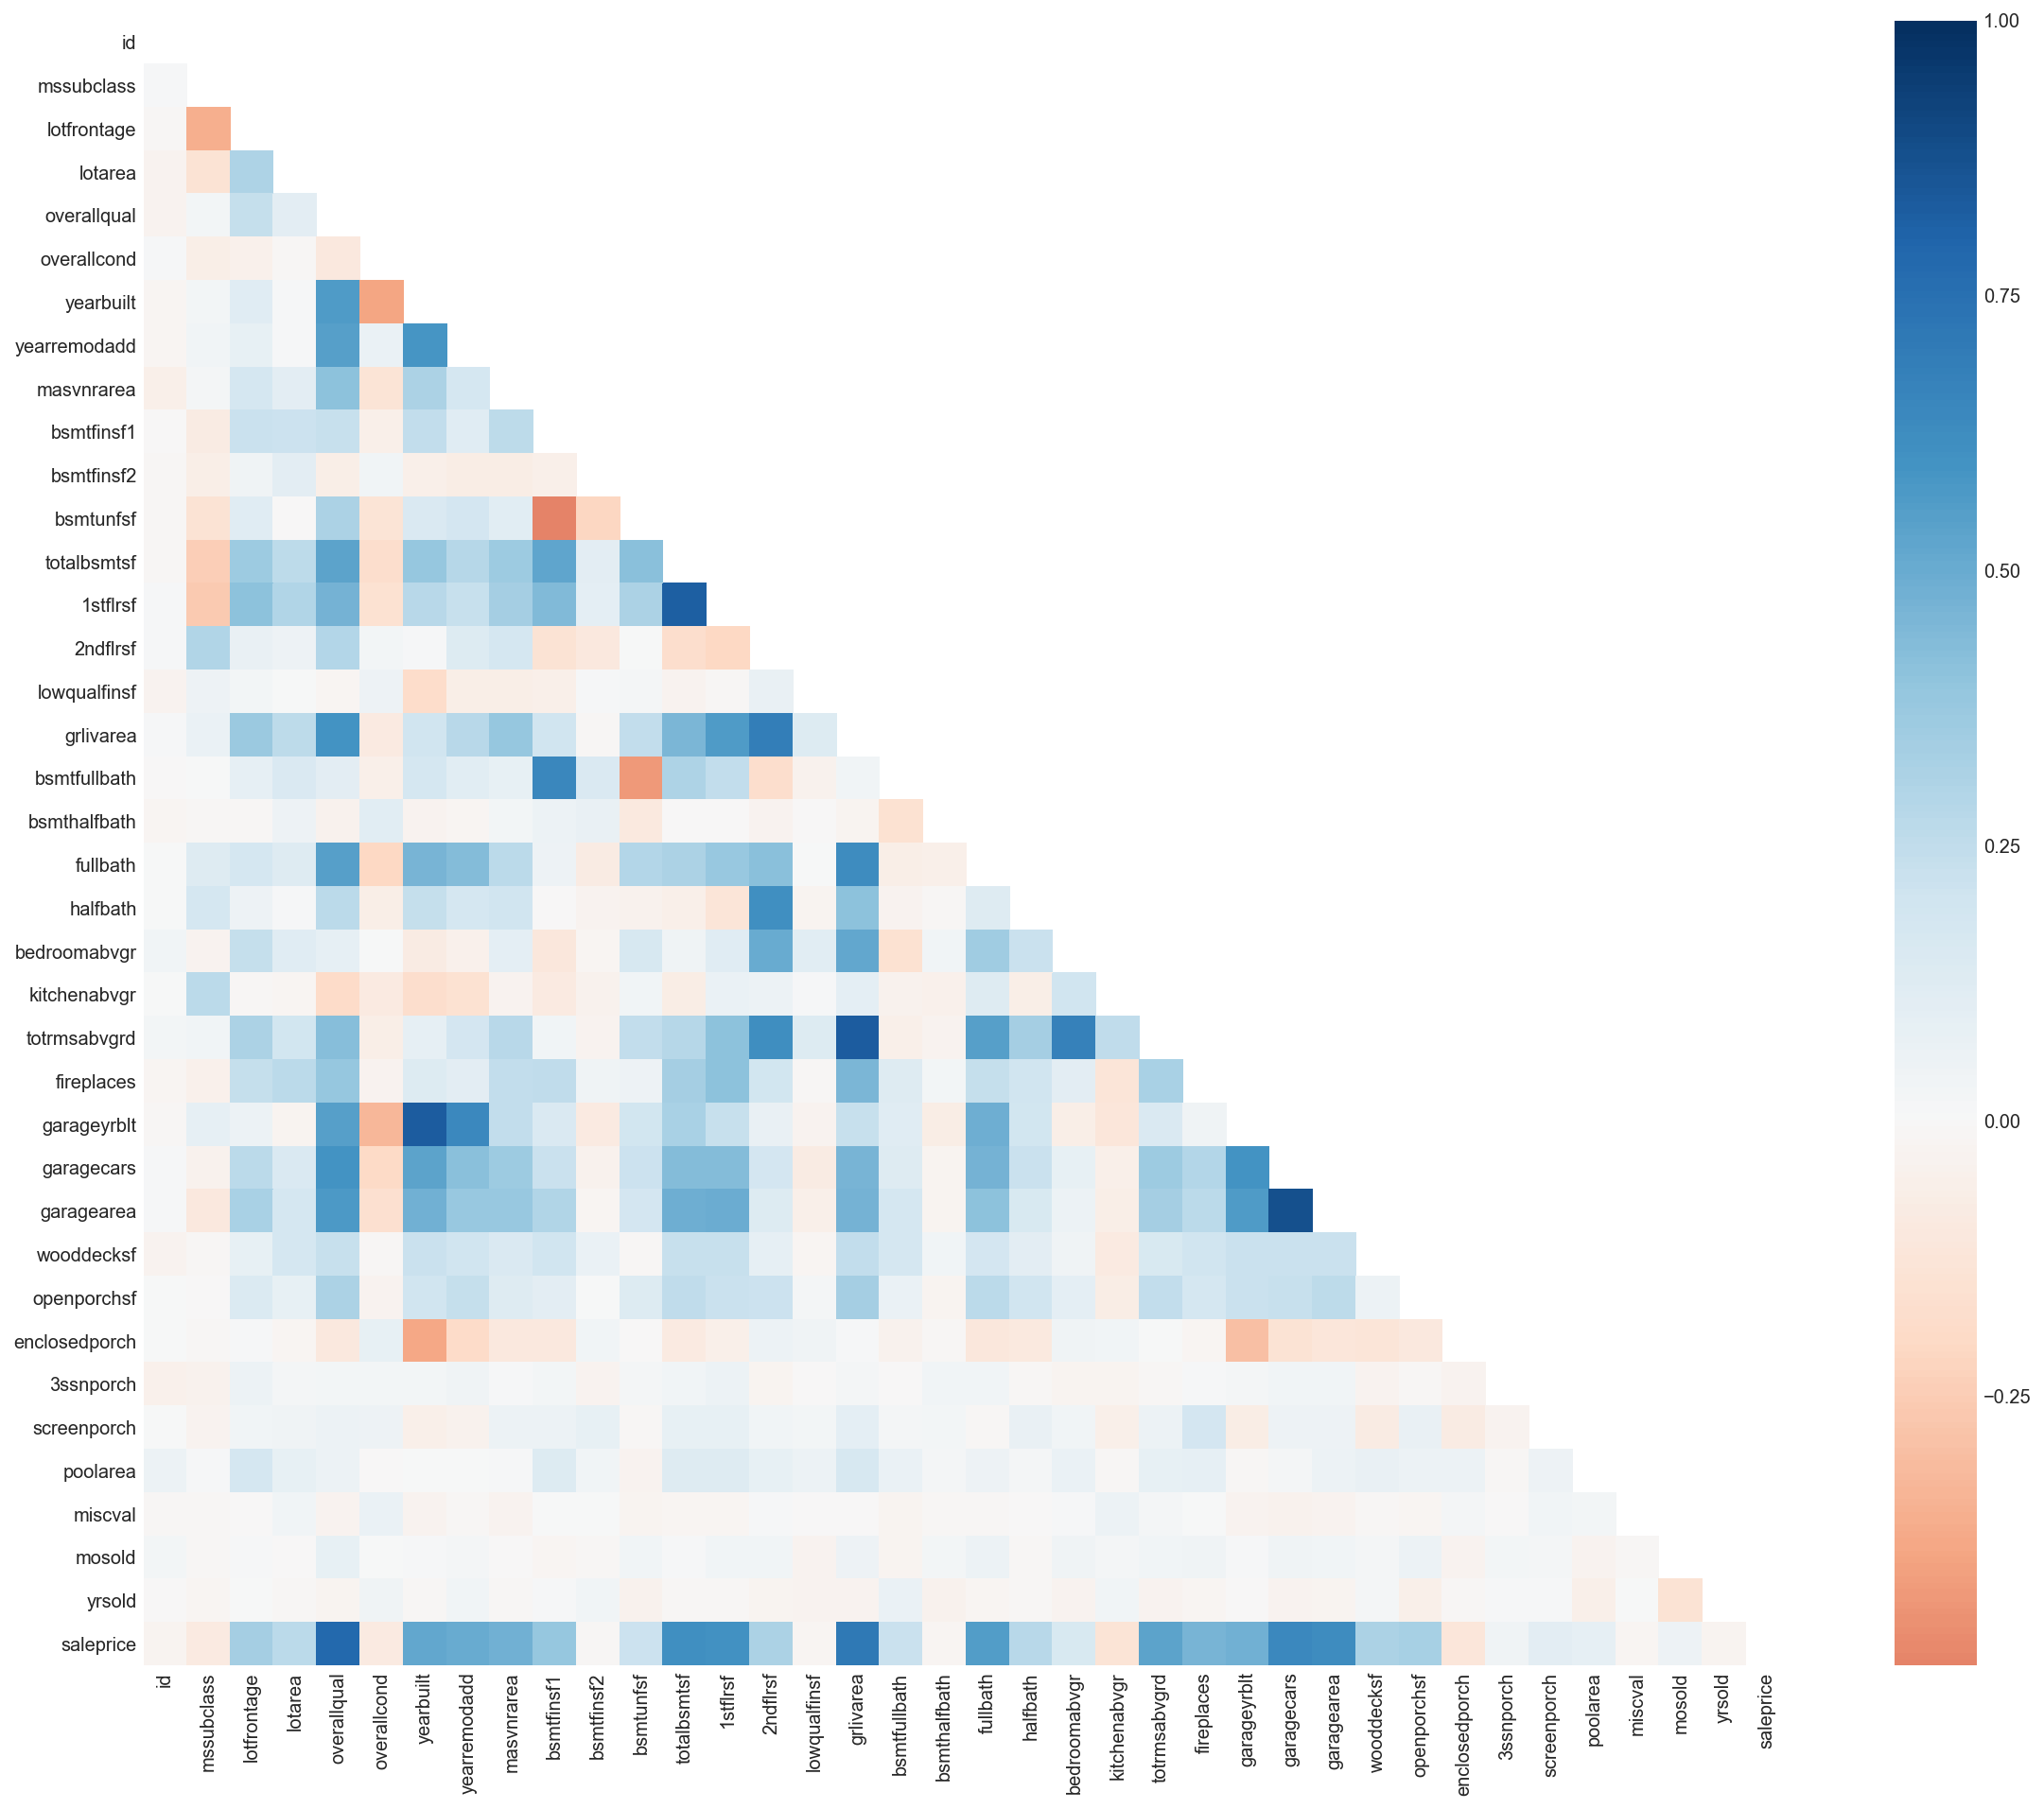

In [12]:
resid_corr = residential.corr()

plt.figure(figsize=(20,16))

mask = np.zeros_like(resid_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(resid_corr,center=0,mask=mask,square=True,cmap='RdBu')

Based on correlation heatmap, the following variables have strong relation to sale price:<br>
overallqual <br>
year built or remod <br>
basement characteristics <br>
above ground house details <br>
garage details

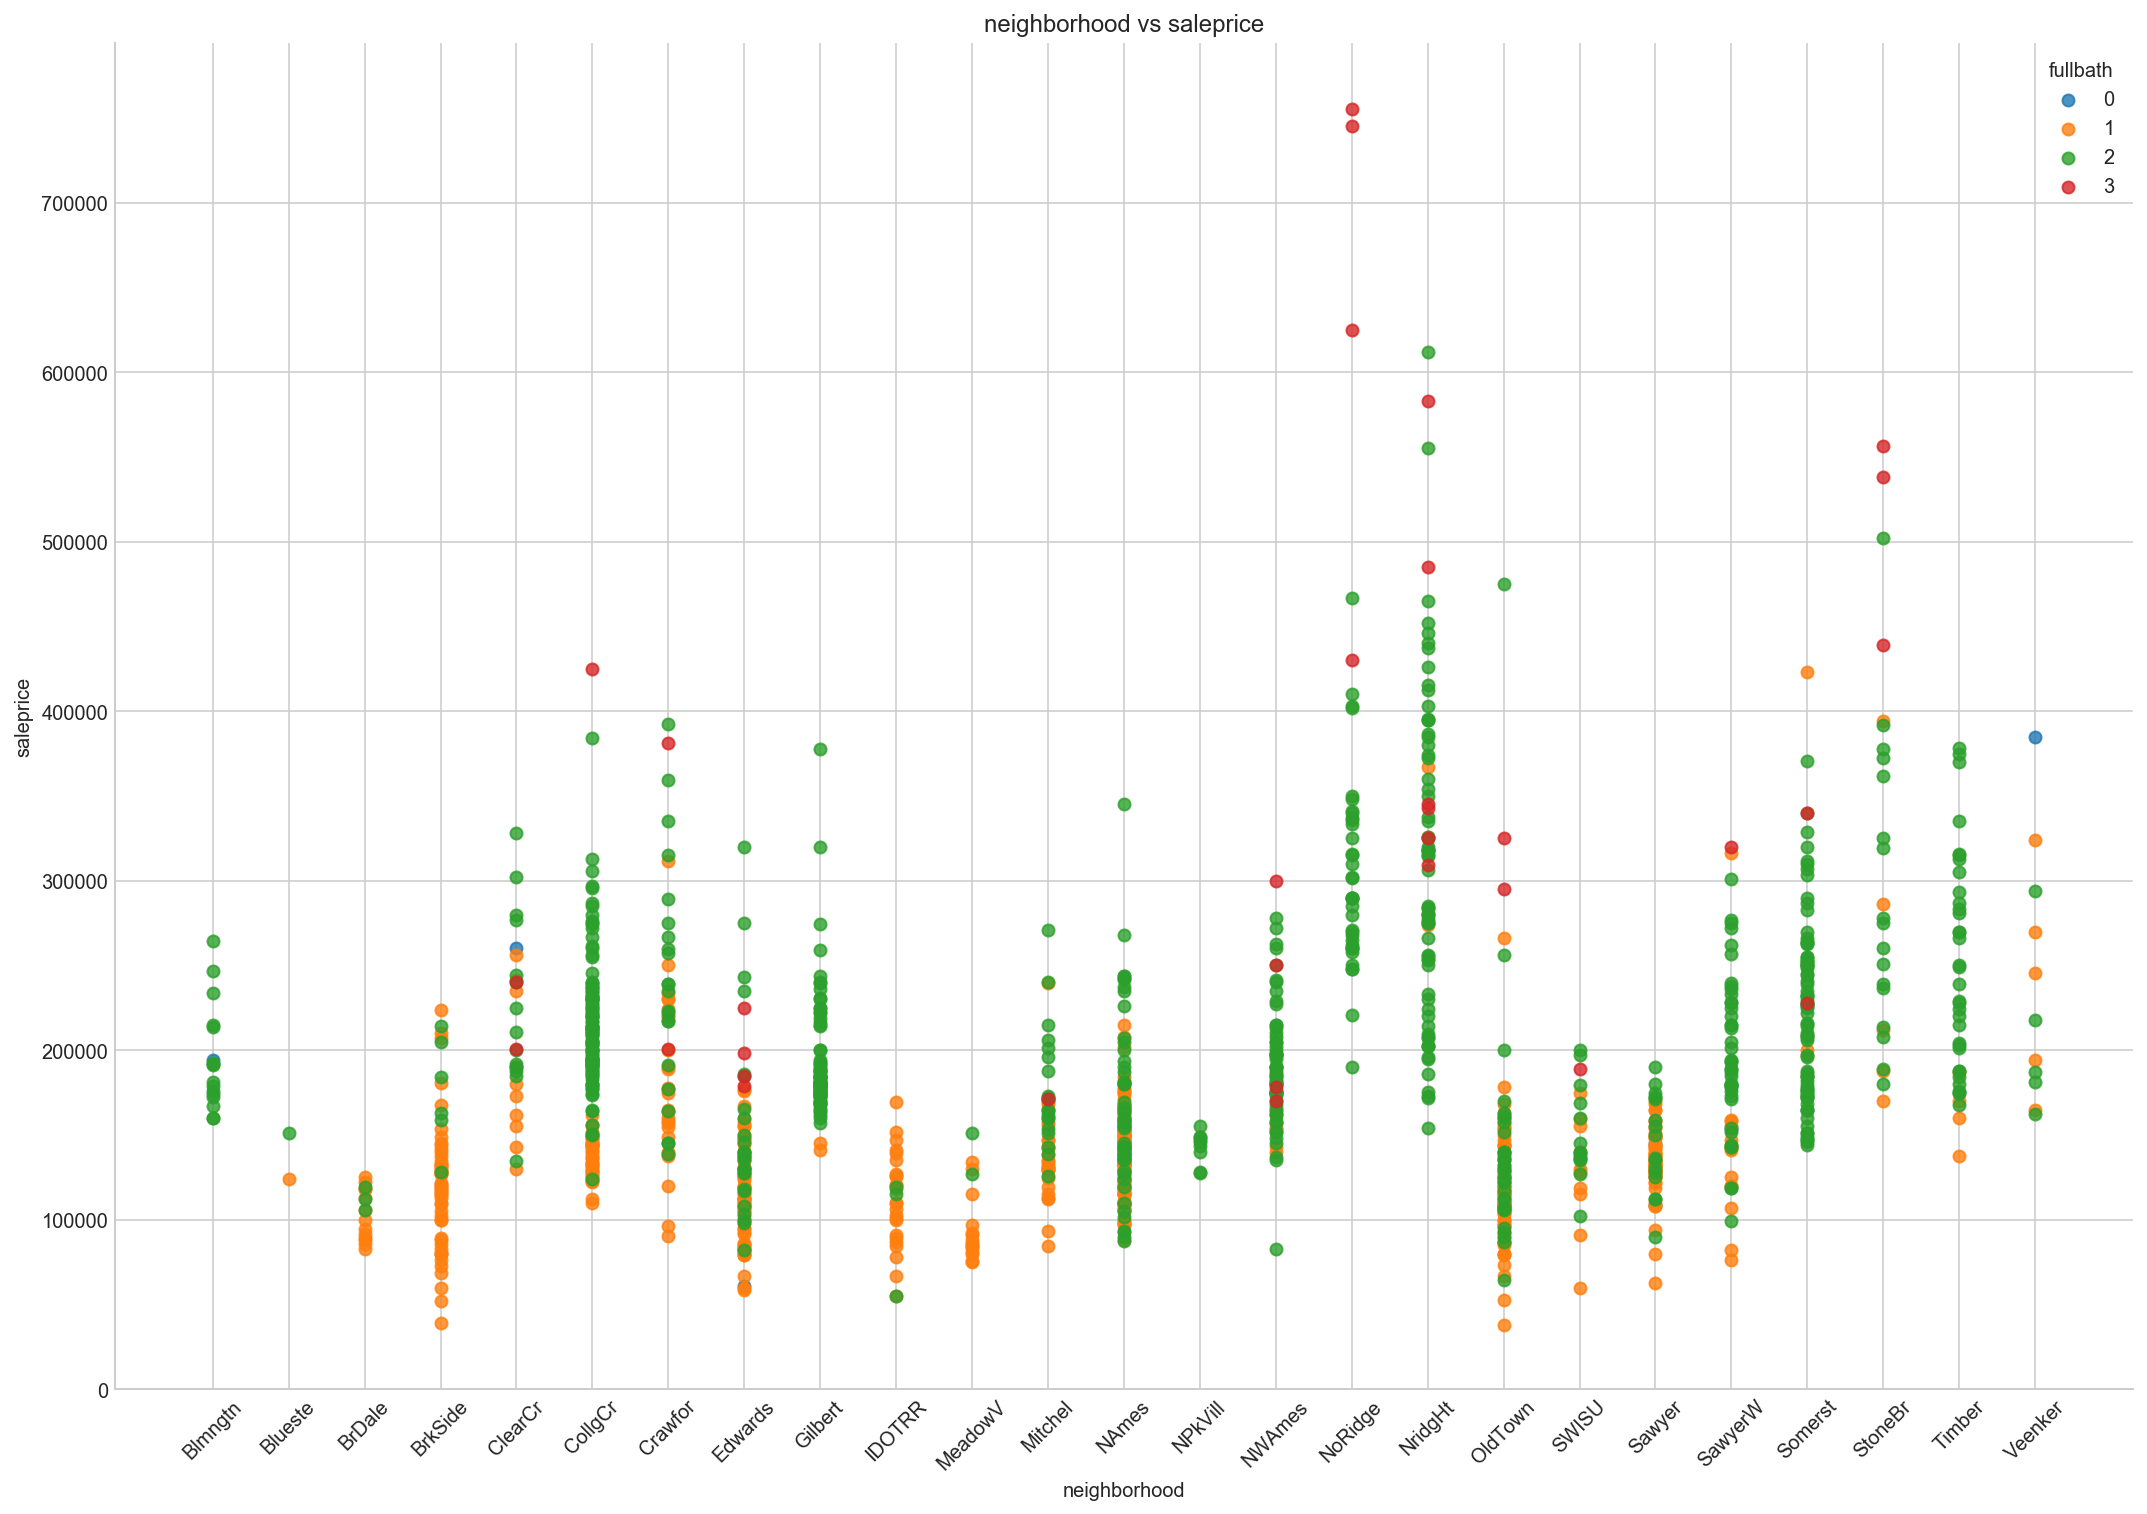

In [13]:
x='neighborhood'
y='saleprice'
lm = sns.lmplot(x=x,y=y,data=residential,hue='fullbath',
                fit_reg=False,size=10,aspect=1.5,legend_out=False)

plt.title('{} vs {}'.format(x,y))
plt.xticks(rotation=45)
plt.ylim(0,)
plt.show()

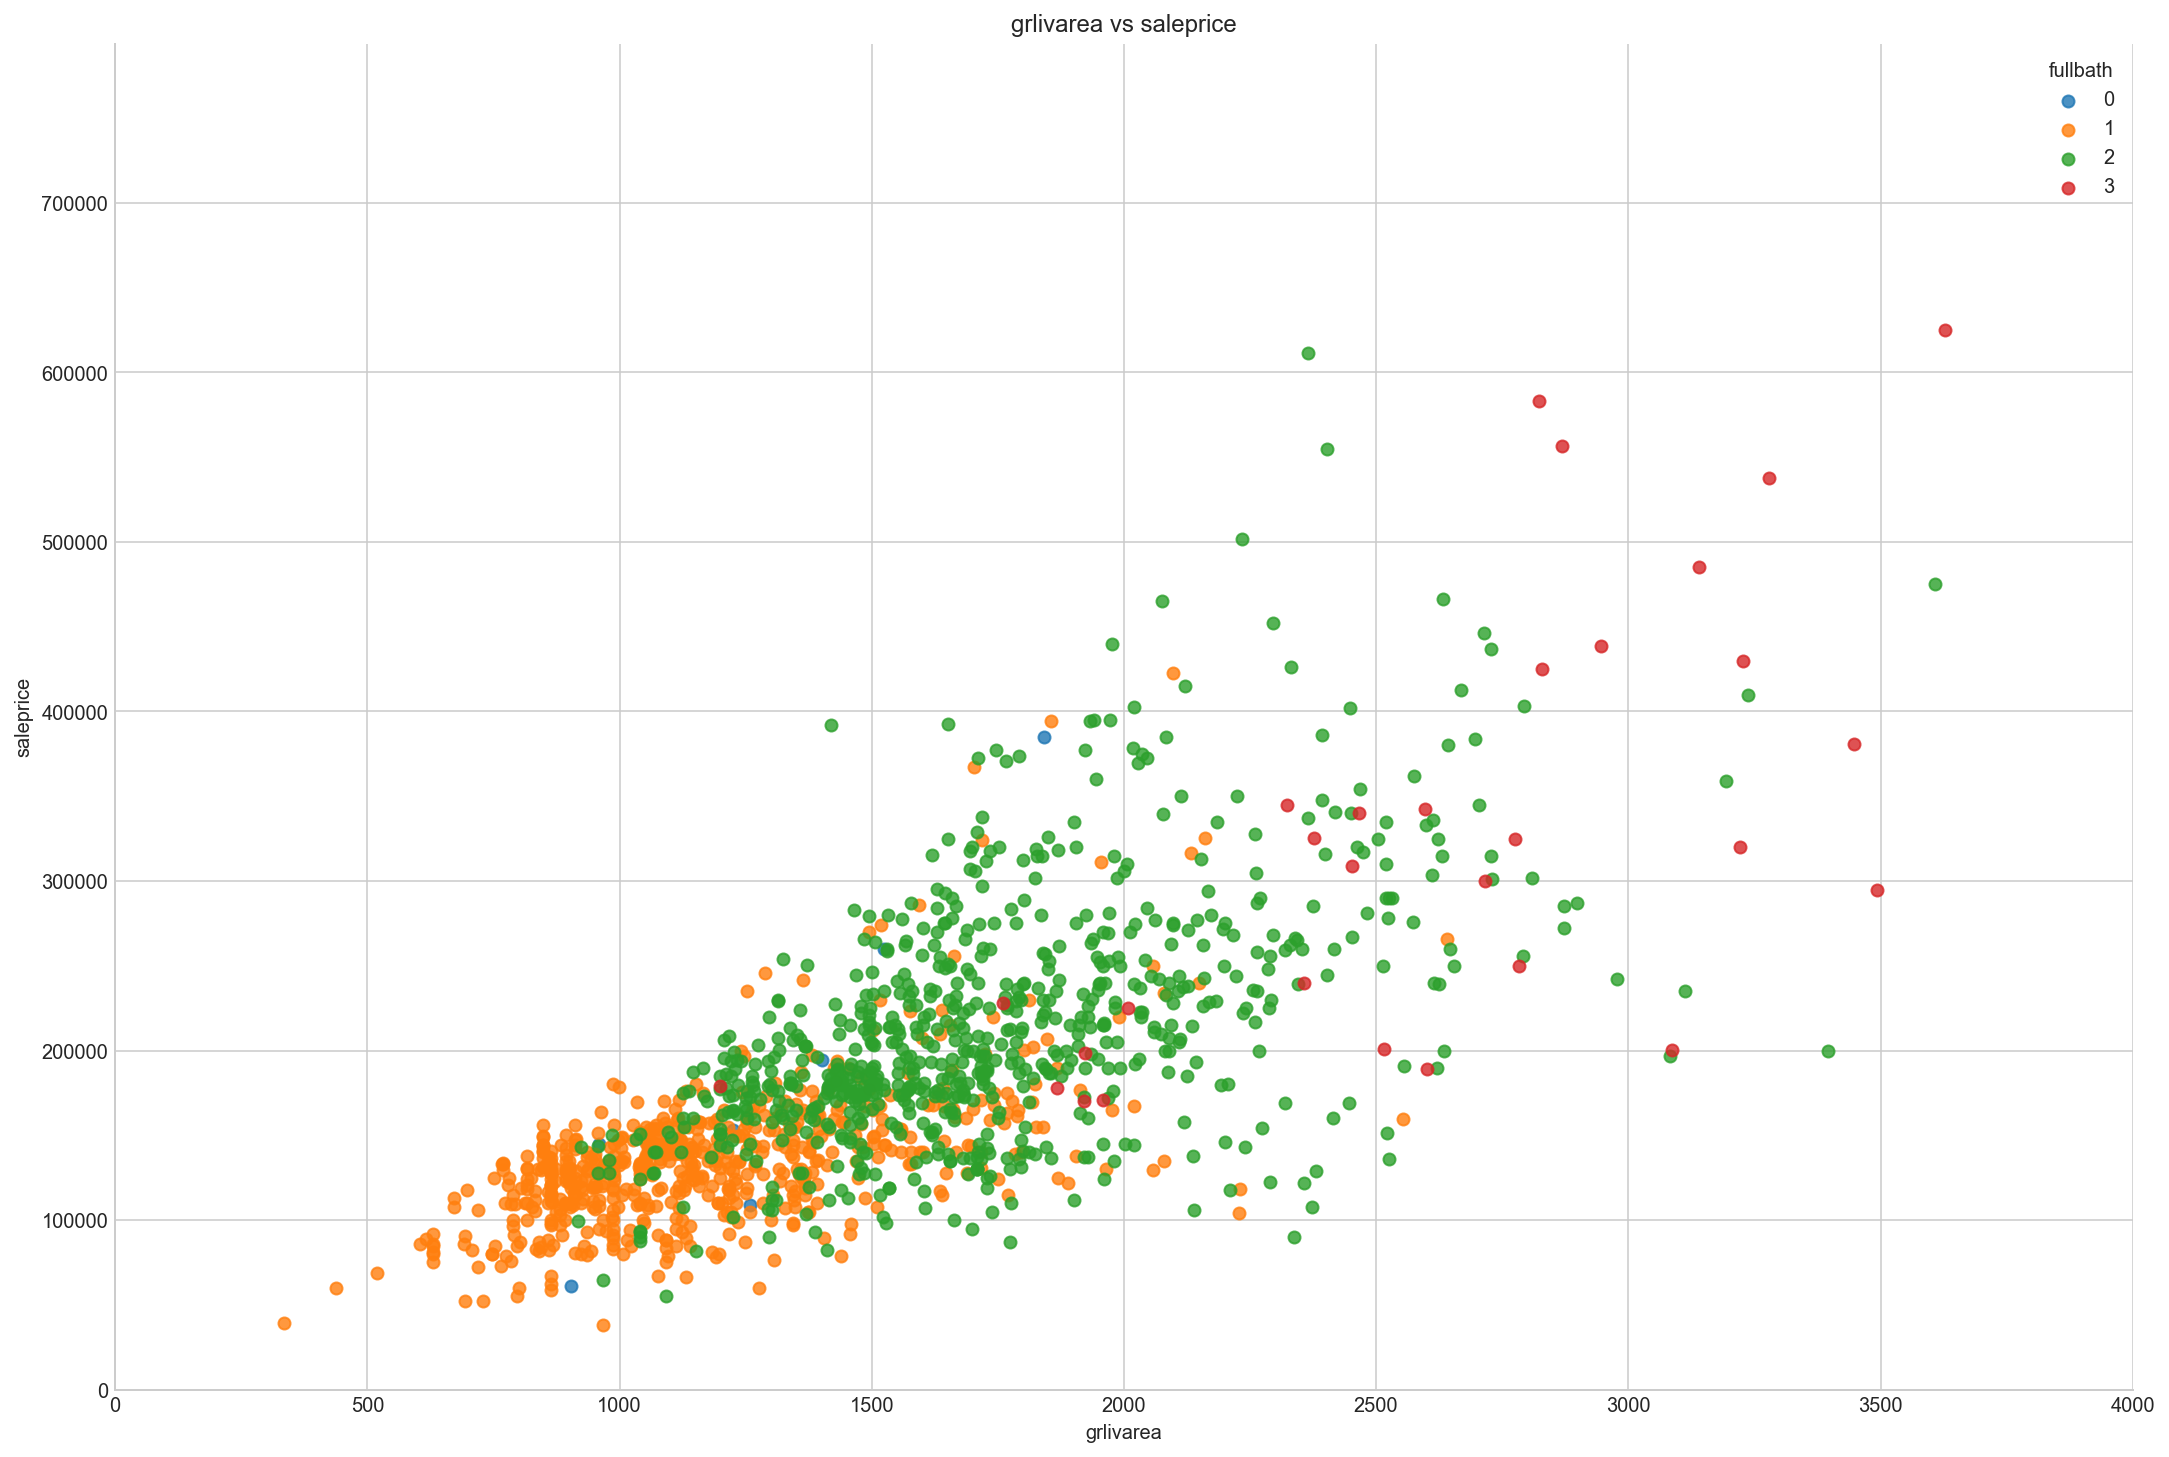

In [14]:
x='grlivarea'
y='saleprice'
lm = sns.lmplot(x=x,y=y,data=residential,hue='fullbath',
                fit_reg=False,size=10,aspect=1.5,legend_out=False)

plt.title('{} vs {}'.format(x,y))
plt.ylim(0,), plt.xlim(0,4000)
plt.show()

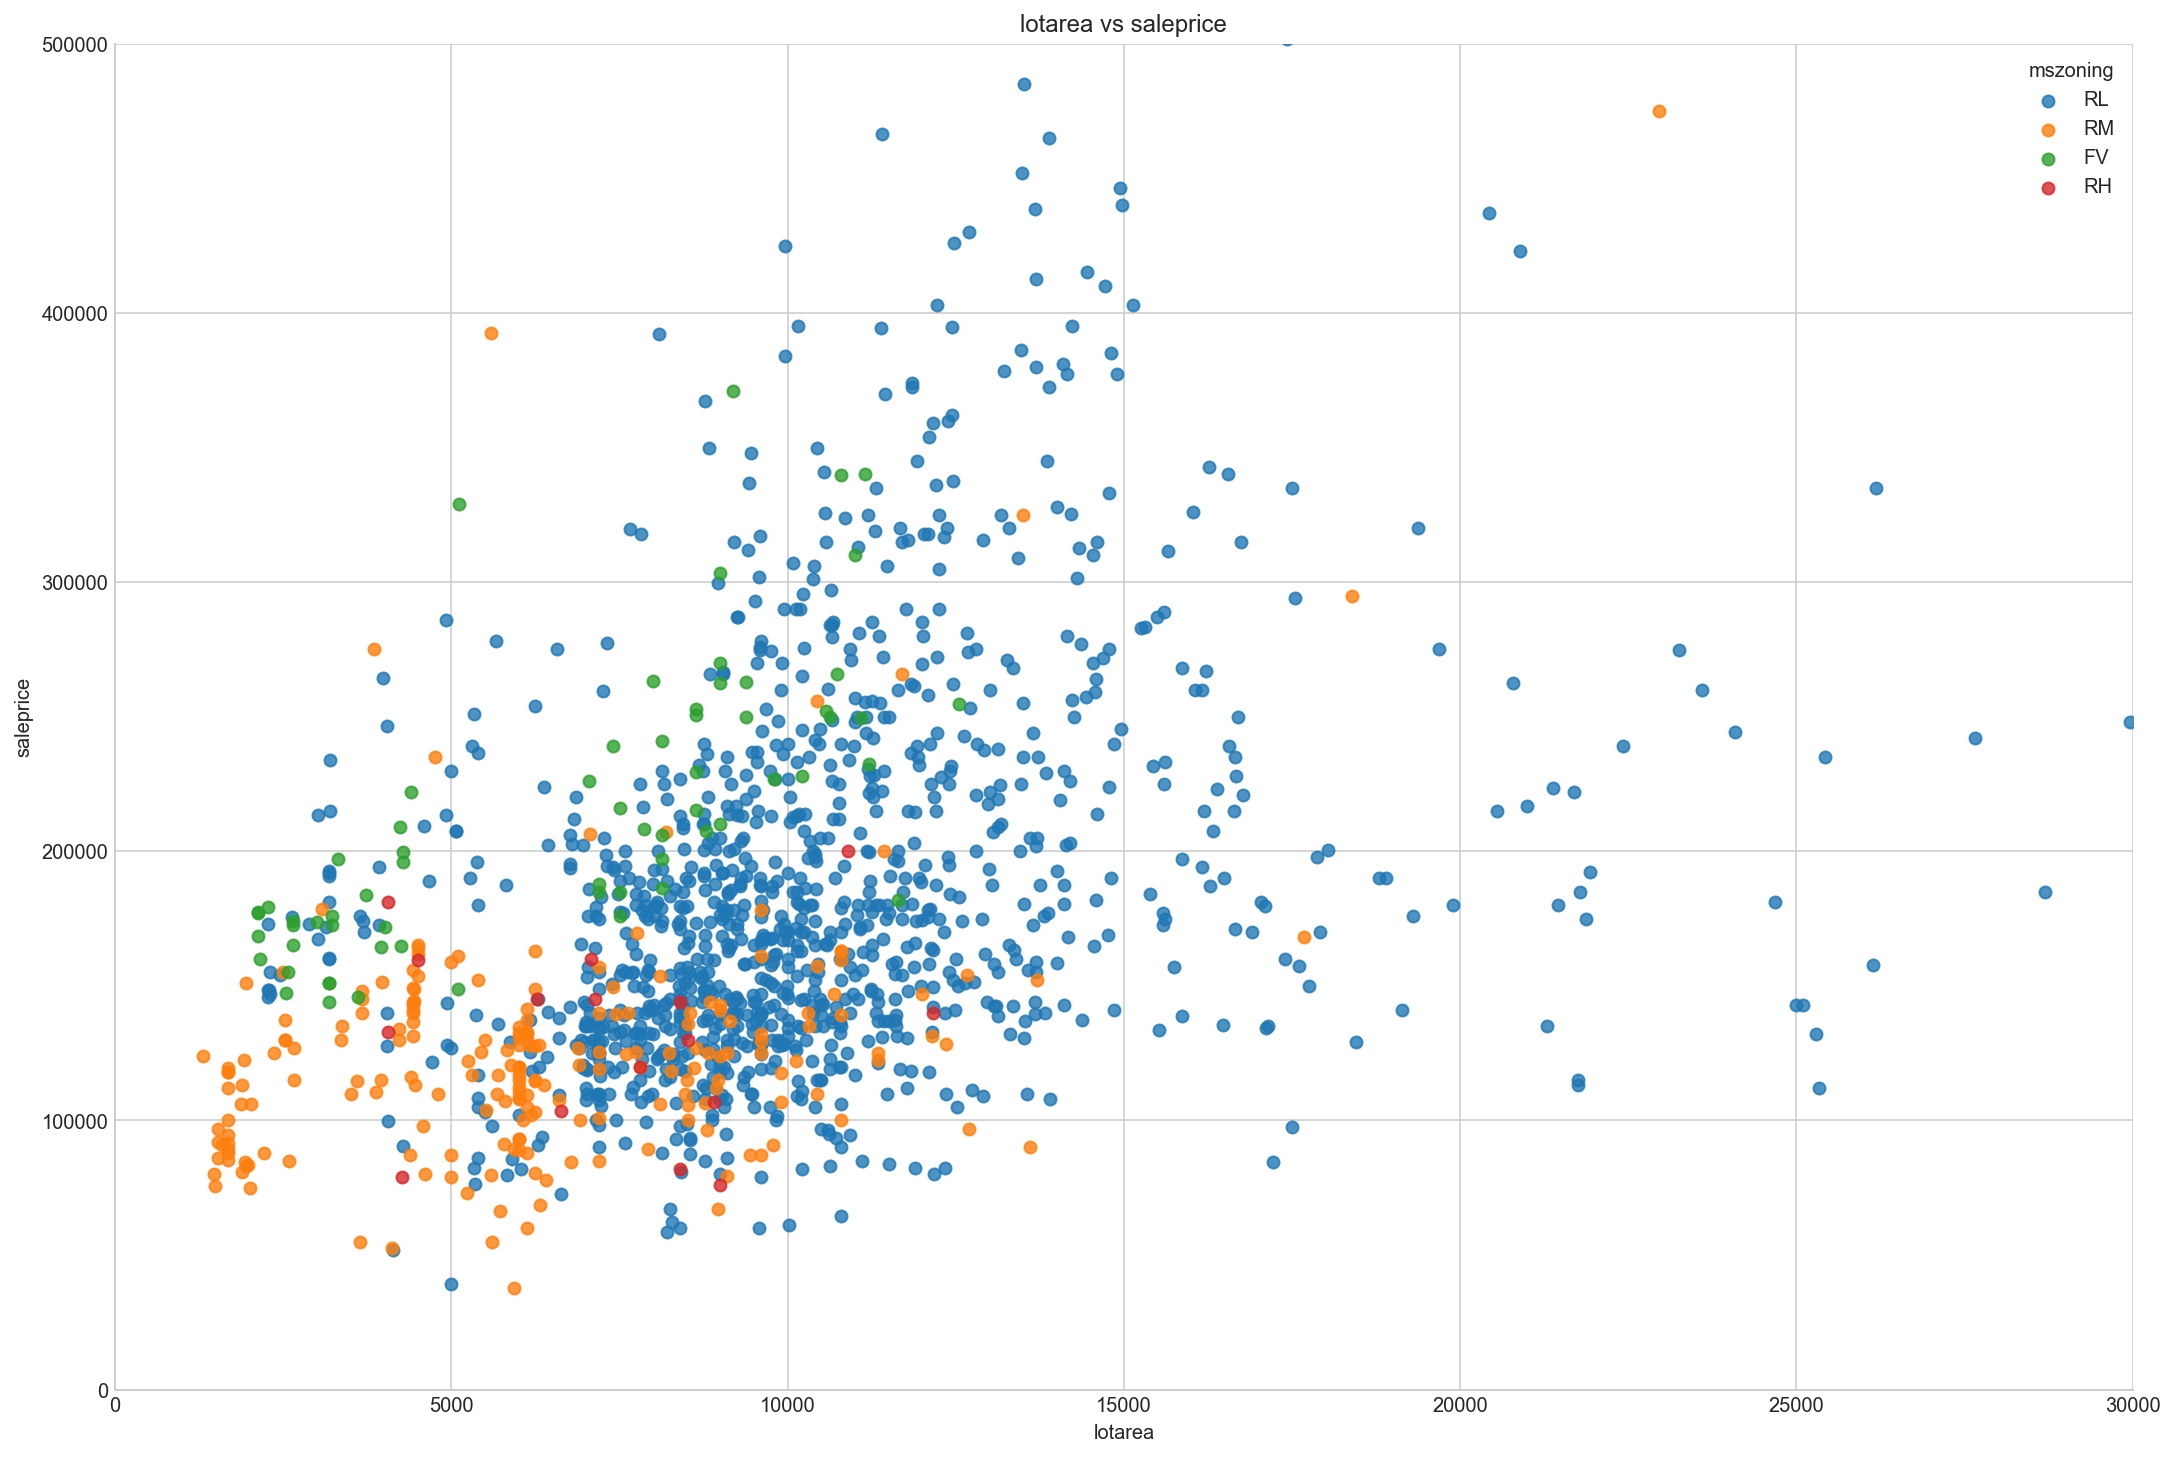

In [15]:
x='lotarea'
y='saleprice'
lm = sns.lmplot(x=x,y=y,data=residential,hue='mszoning',
                fit_reg=False,size=10,aspect=1.5,legend_out=False)

plt.title('{} vs {}'.format(x,y))
plt.ylim(0,500000), plt.xlim(0,30000)
plt.show()

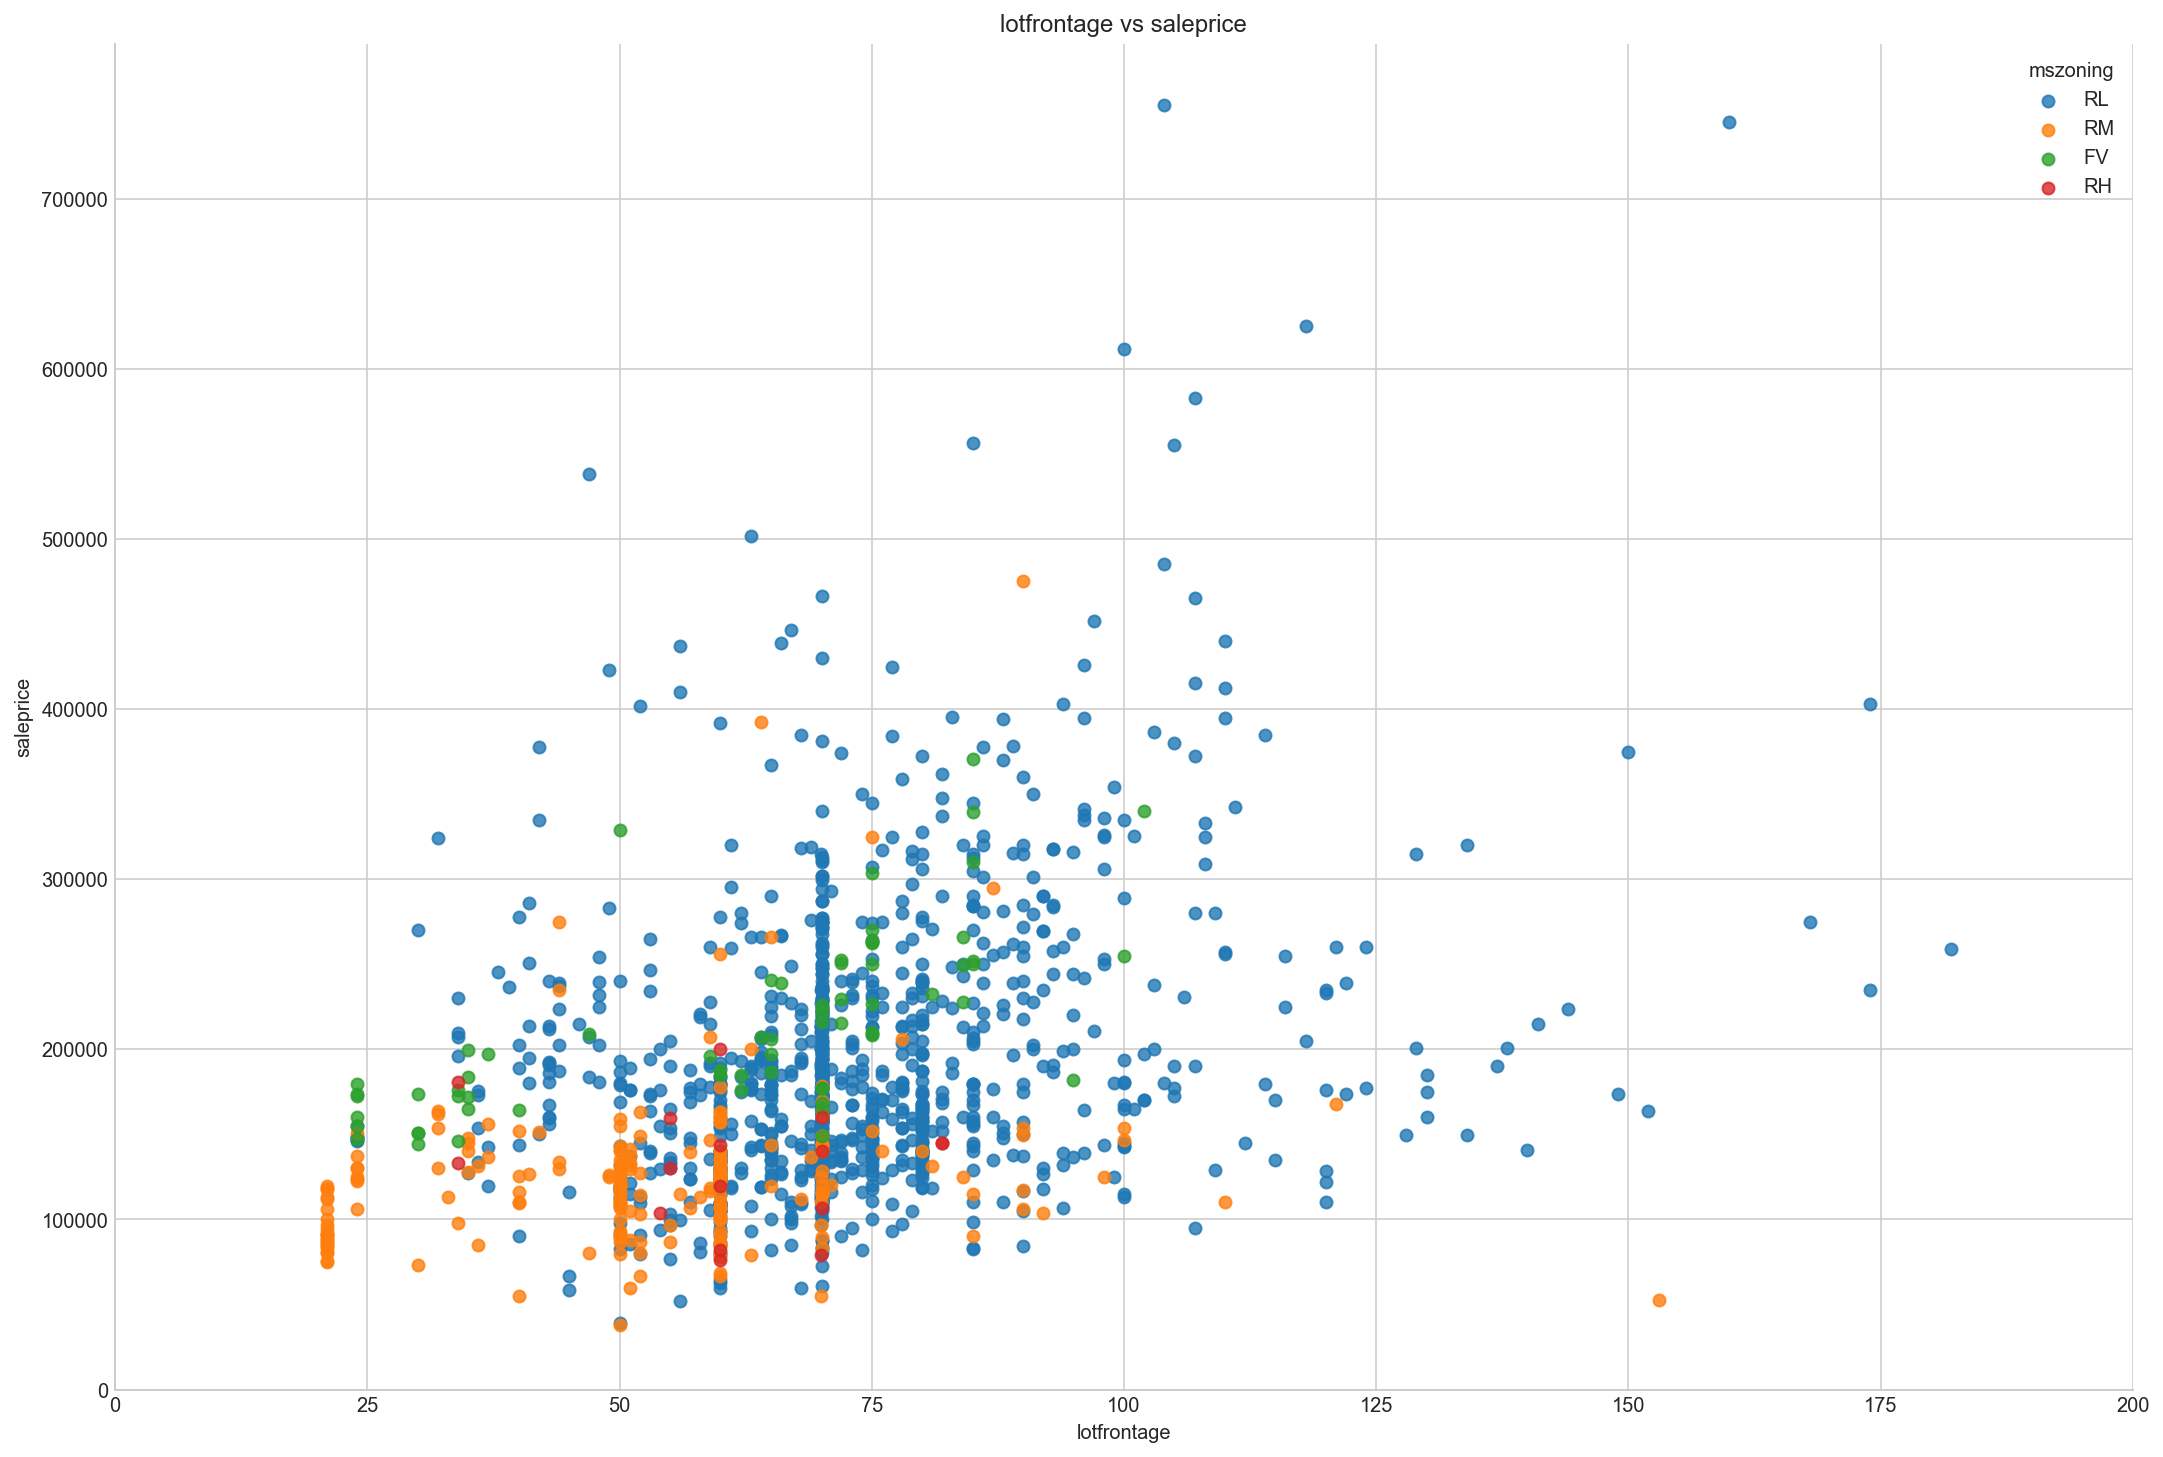

In [16]:
x='lotfrontage'
y='saleprice'
lm = sns.lmplot(x=x,y=y,data=residential,hue='mszoning',
                fit_reg=False,size=10,aspect=1.5,legend_out=False)

plt.title('{} vs {}'.format(x,y))
plt.ylim(0,), plt.xlim(0,200)
plt.show()

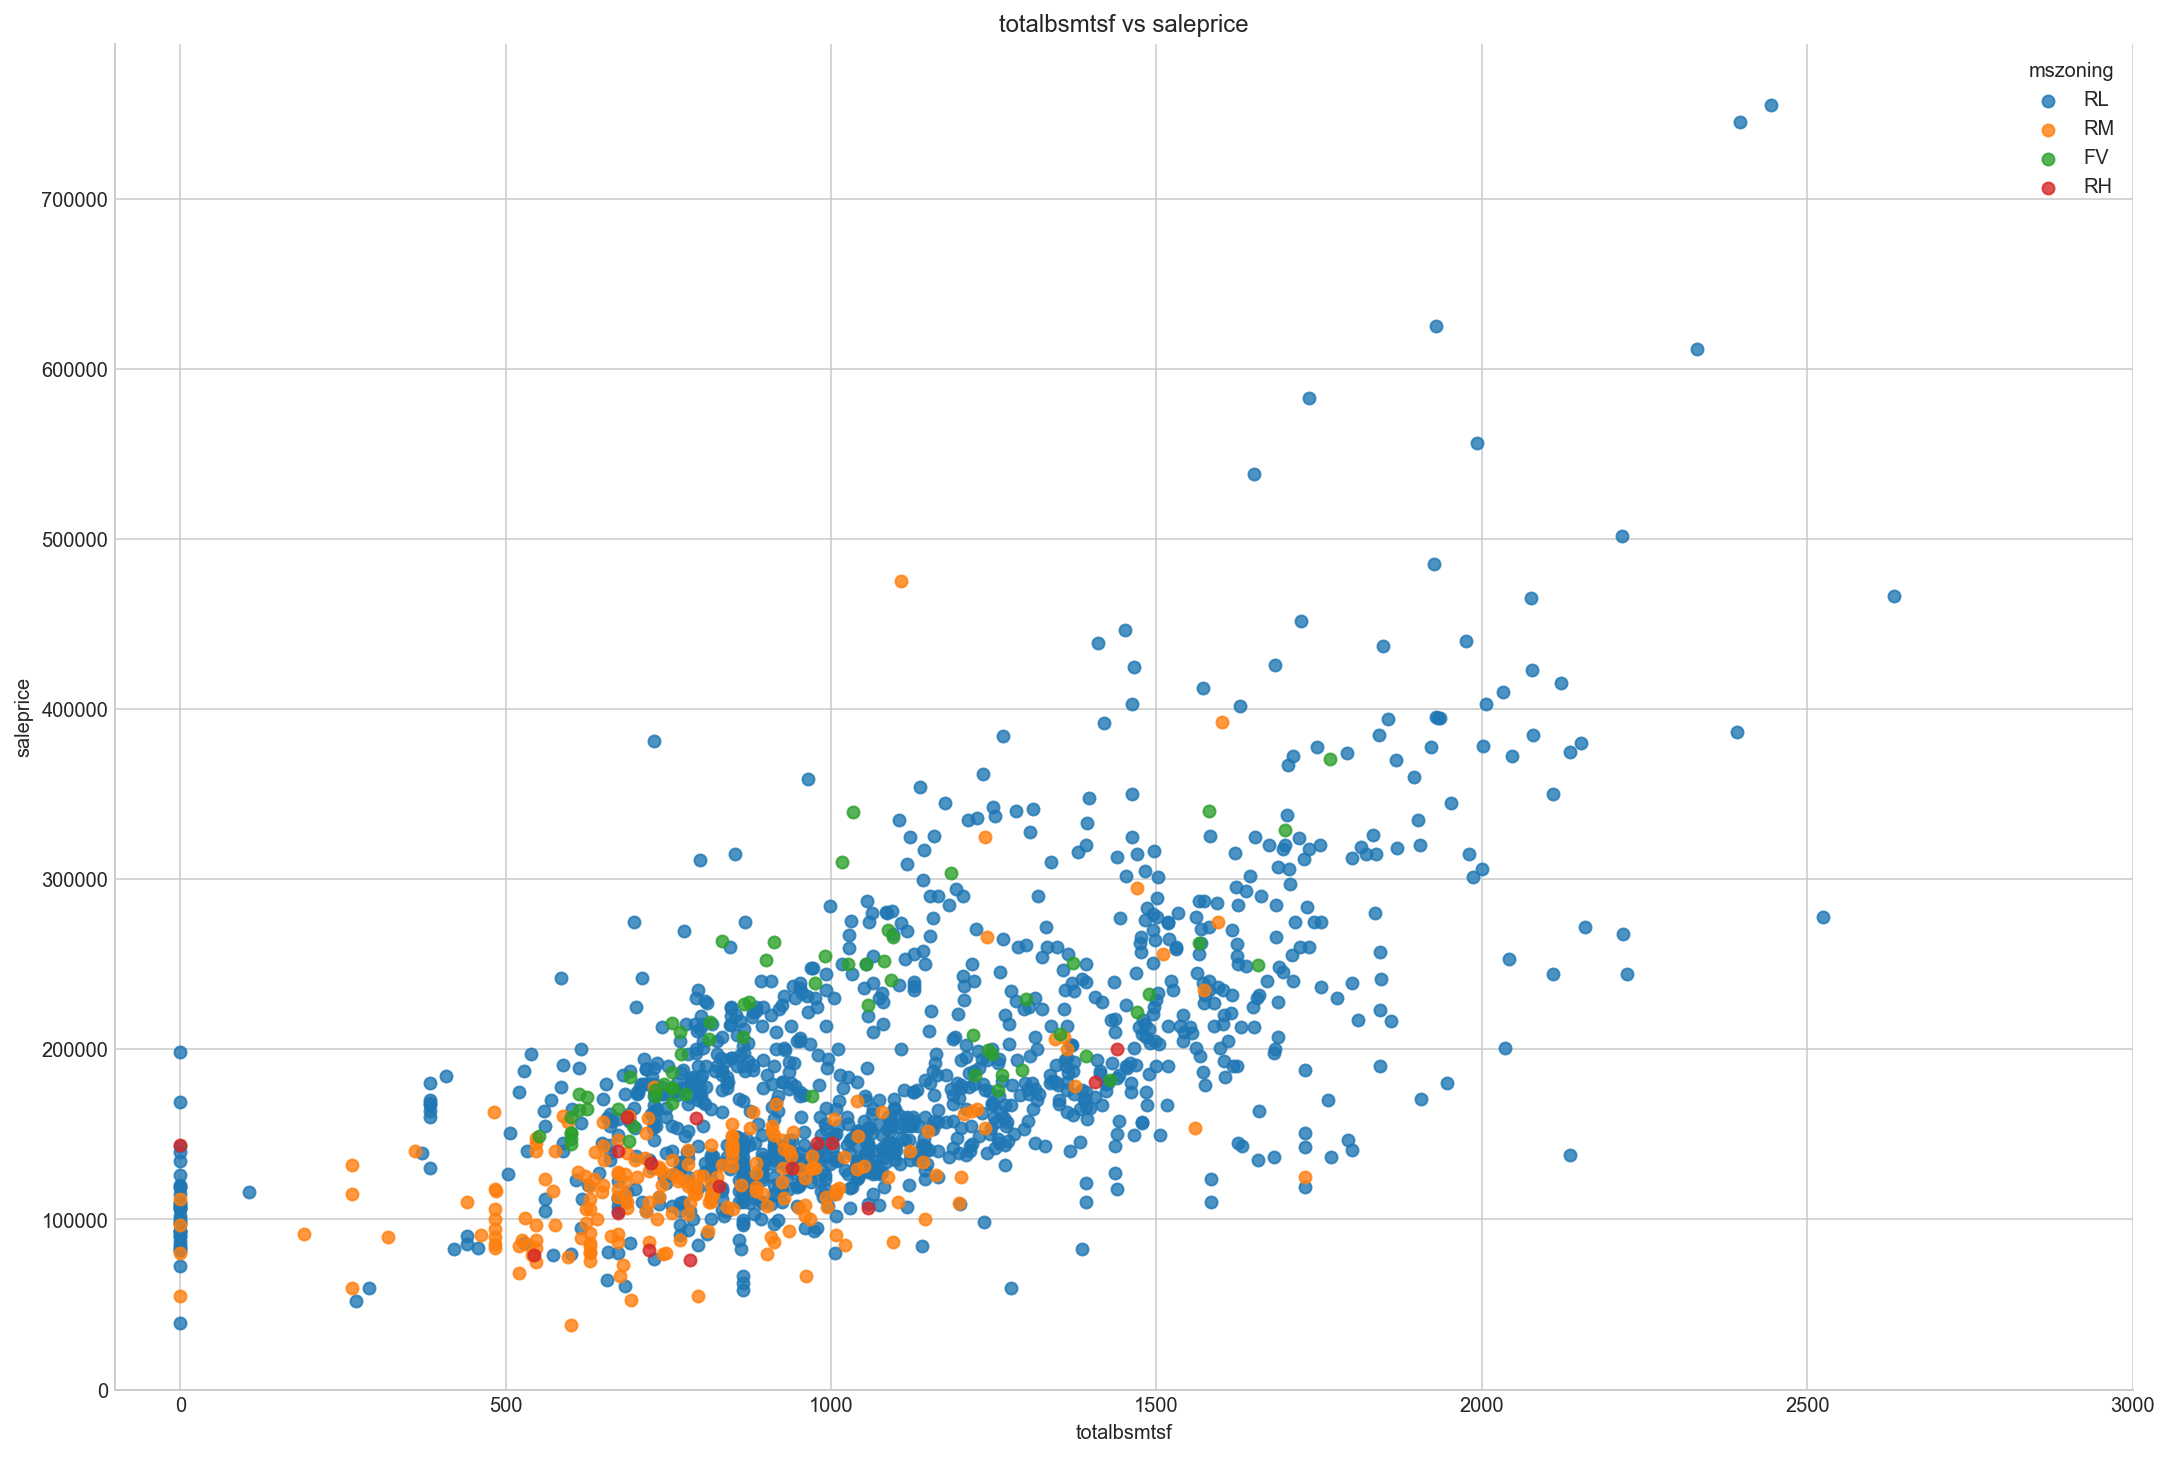

In [17]:
x='totalbsmtsf'
y='saleprice'
lm = sns.lmplot(x=x,y=y,data=residential,hue='mszoning',
                fit_reg=False,size=10,aspect=1.5,legend_out=False)

plt.title('{} vs {}'.format(x,y))
plt.ylim(0,), plt.xlim(-100,3000)
plt.show()

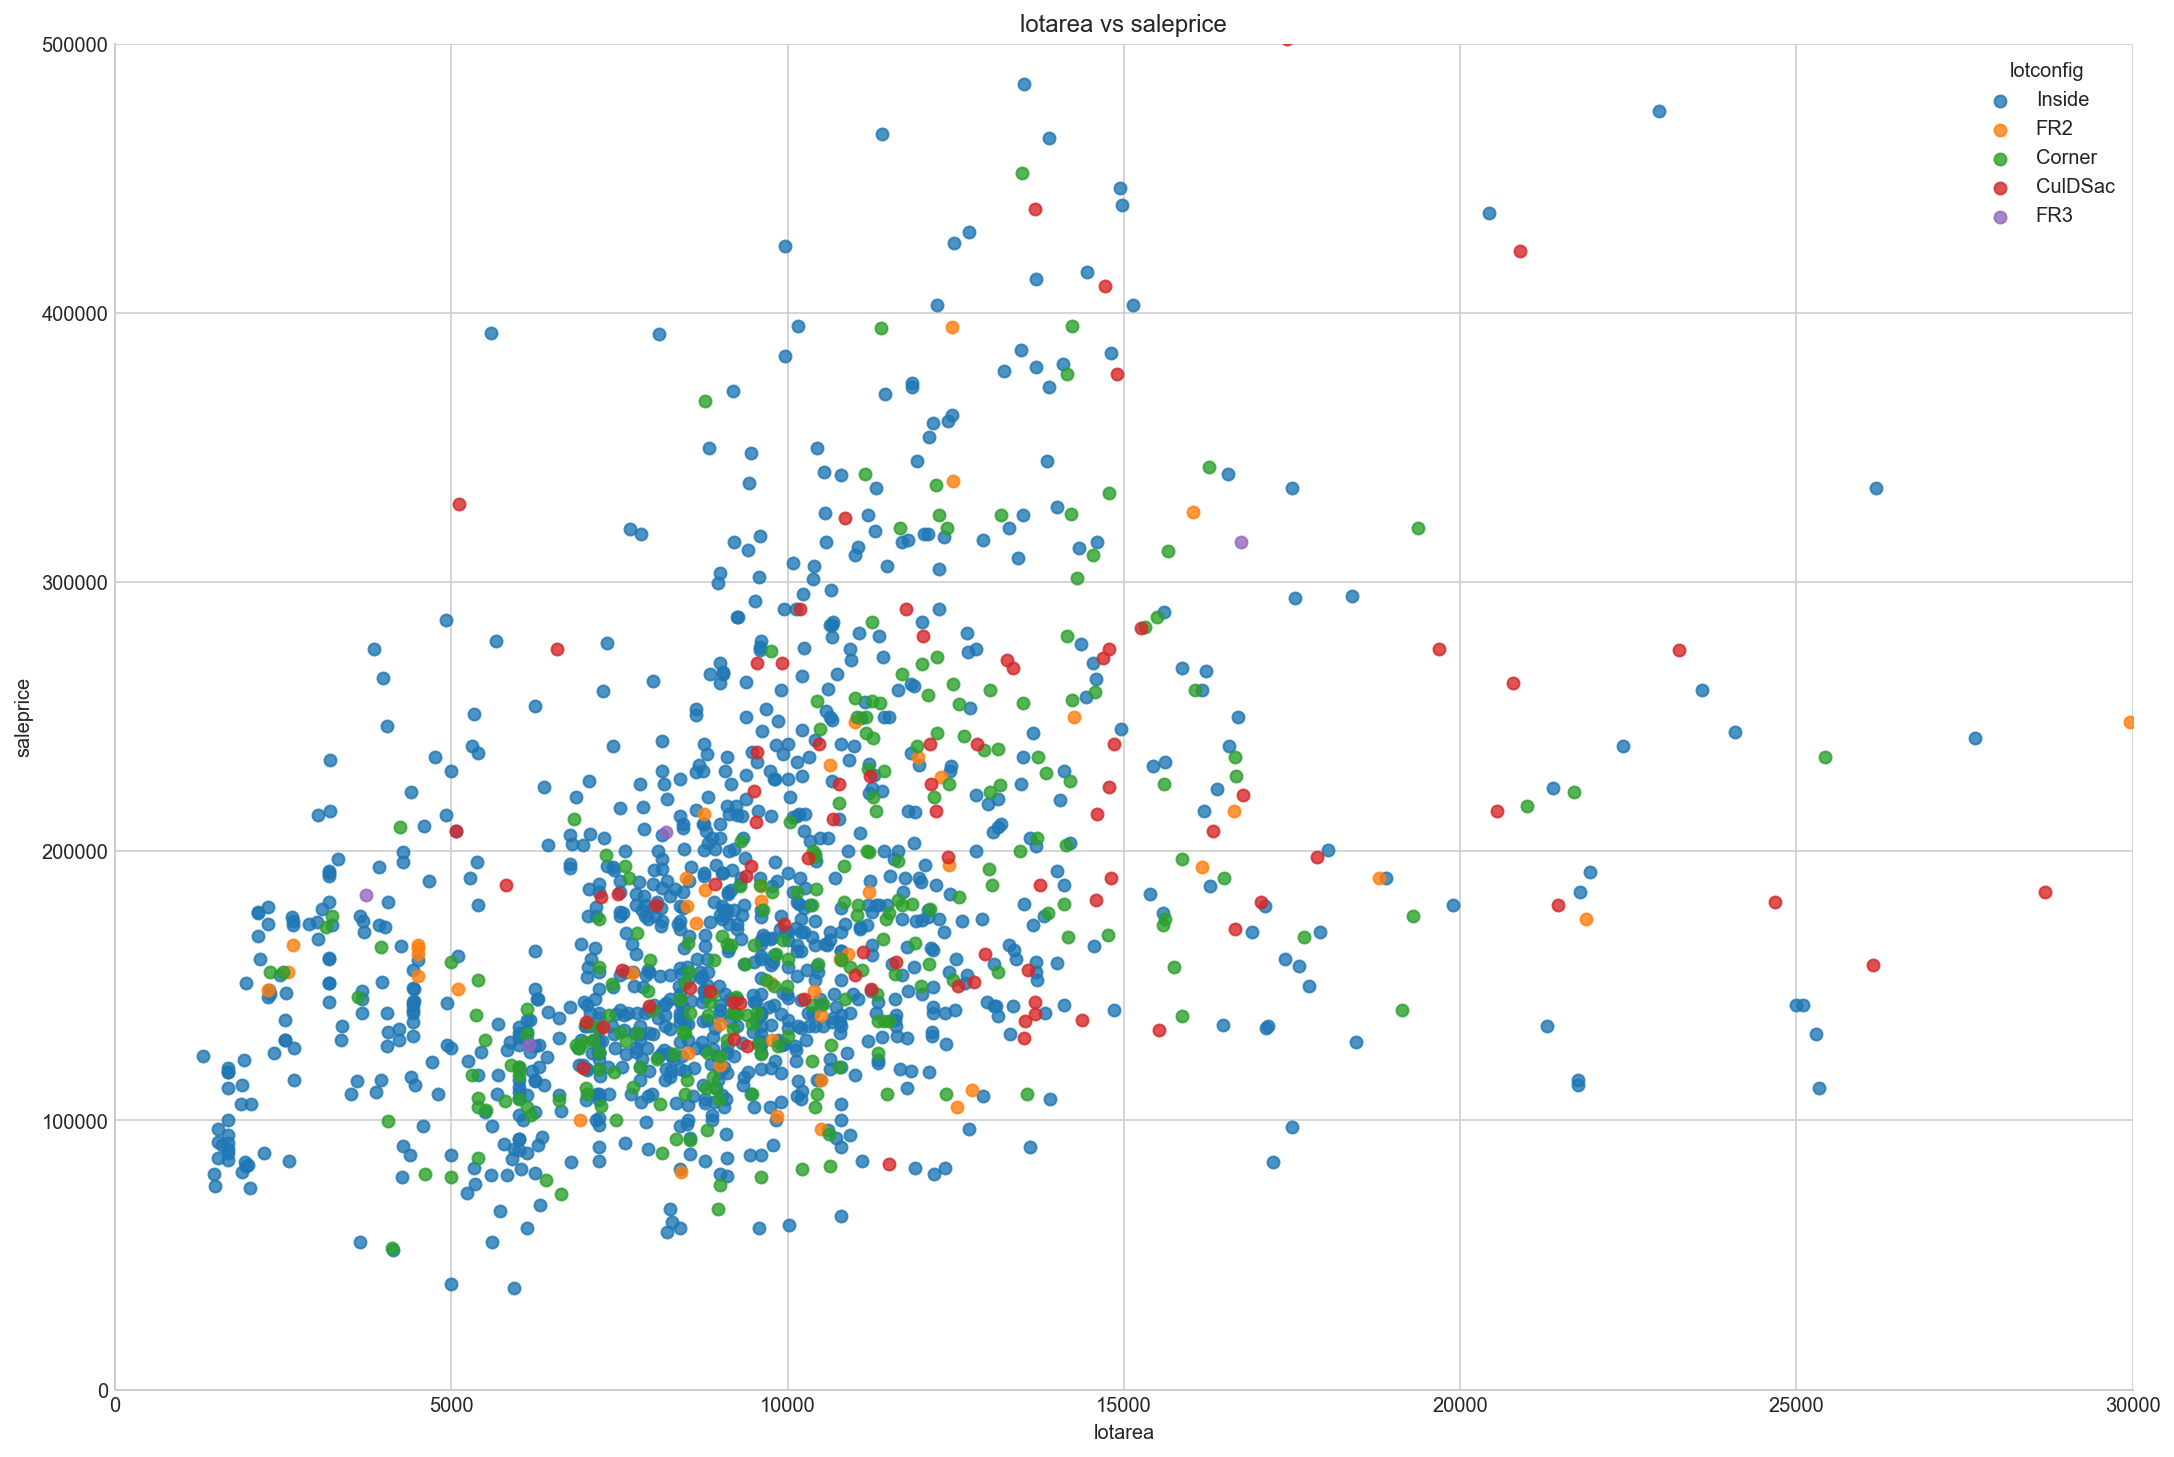

In [18]:
x='lotarea'
y='saleprice'
lm = sns.lmplot(x=x,y=y,data=residential,hue='lotconfig',
                fit_reg=False,size=10,aspect=1.5,legend_out=False)

plt.title('{} vs {}'.format(x,y))
plt.ylim(0,500000), plt.xlim(0,30000)
plt.show()

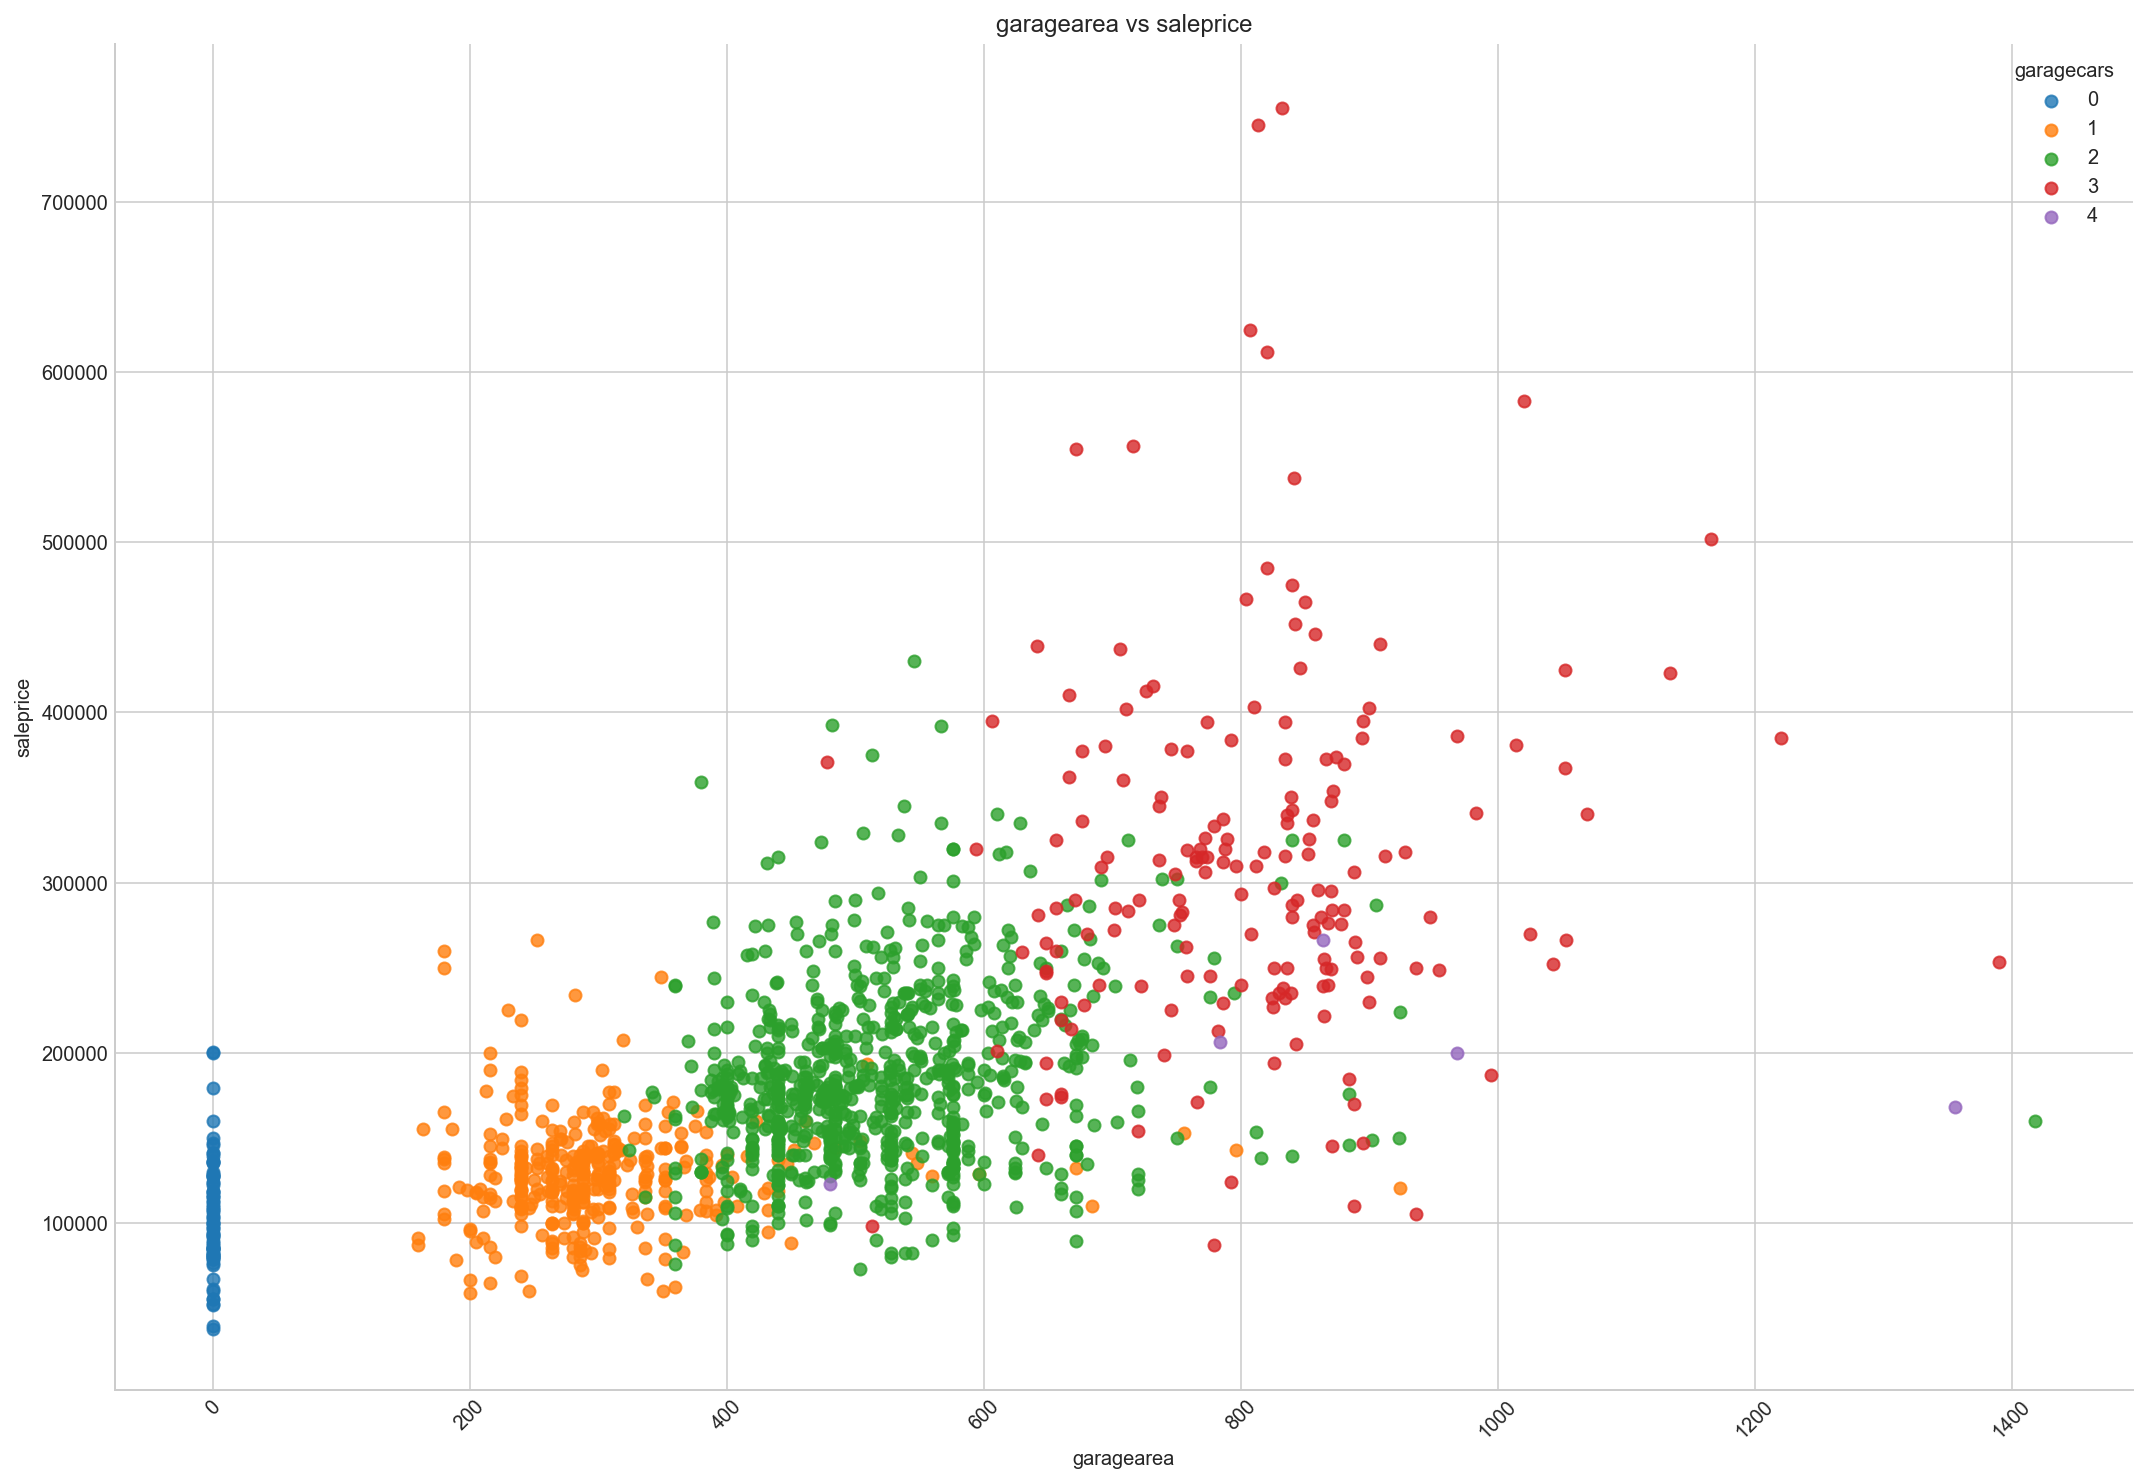

In [19]:
x='garagearea'
y='saleprice'
lm = sns.lmplot(x=x,y=y,data=residential,hue='garagecars',
                fit_reg=False,size=10,aspect=1.5,legend_out=False)

plt.title('{} vs {}'.format(x,y))
plt.xticks(rotation=45)
plt.show()

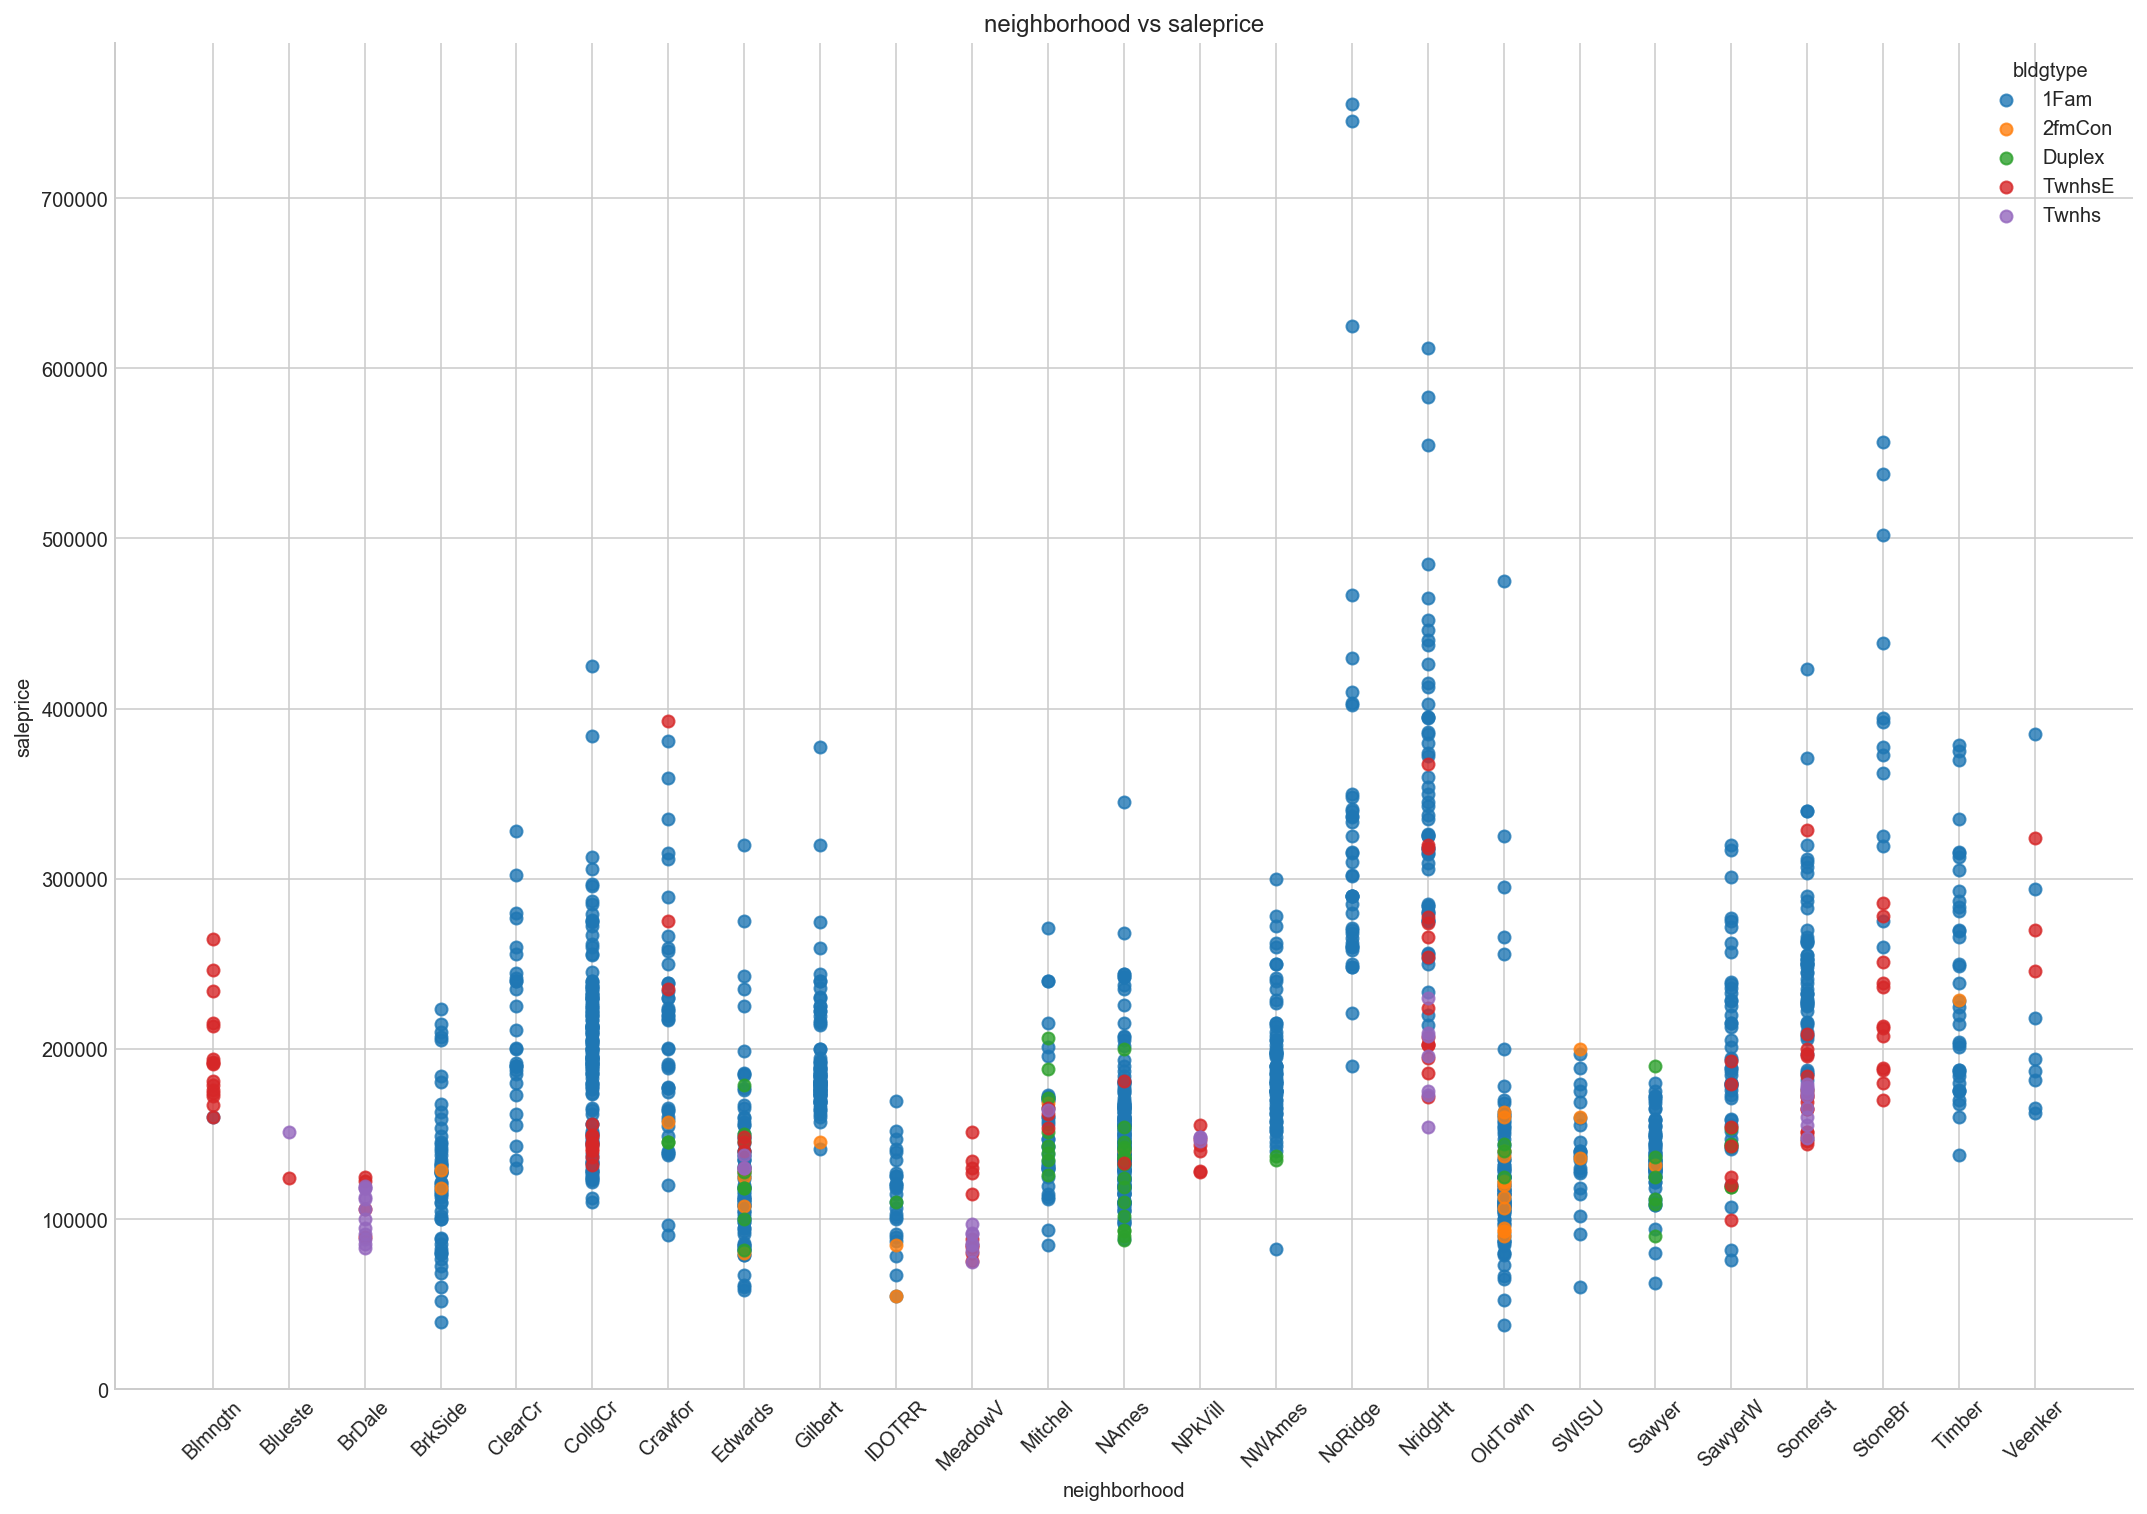

In [20]:
x='neighborhood'
y='saleprice'
lm = sns.lmplot(x=x,y=y,data=residential,hue='bldgtype',
                fit_reg=False,size=10,aspect=1.5,legend_out=False)

plt.title('{} vs {}'.format(x,y))
plt.xticks(rotation=45)
plt.ylim(0,)
plt.show()

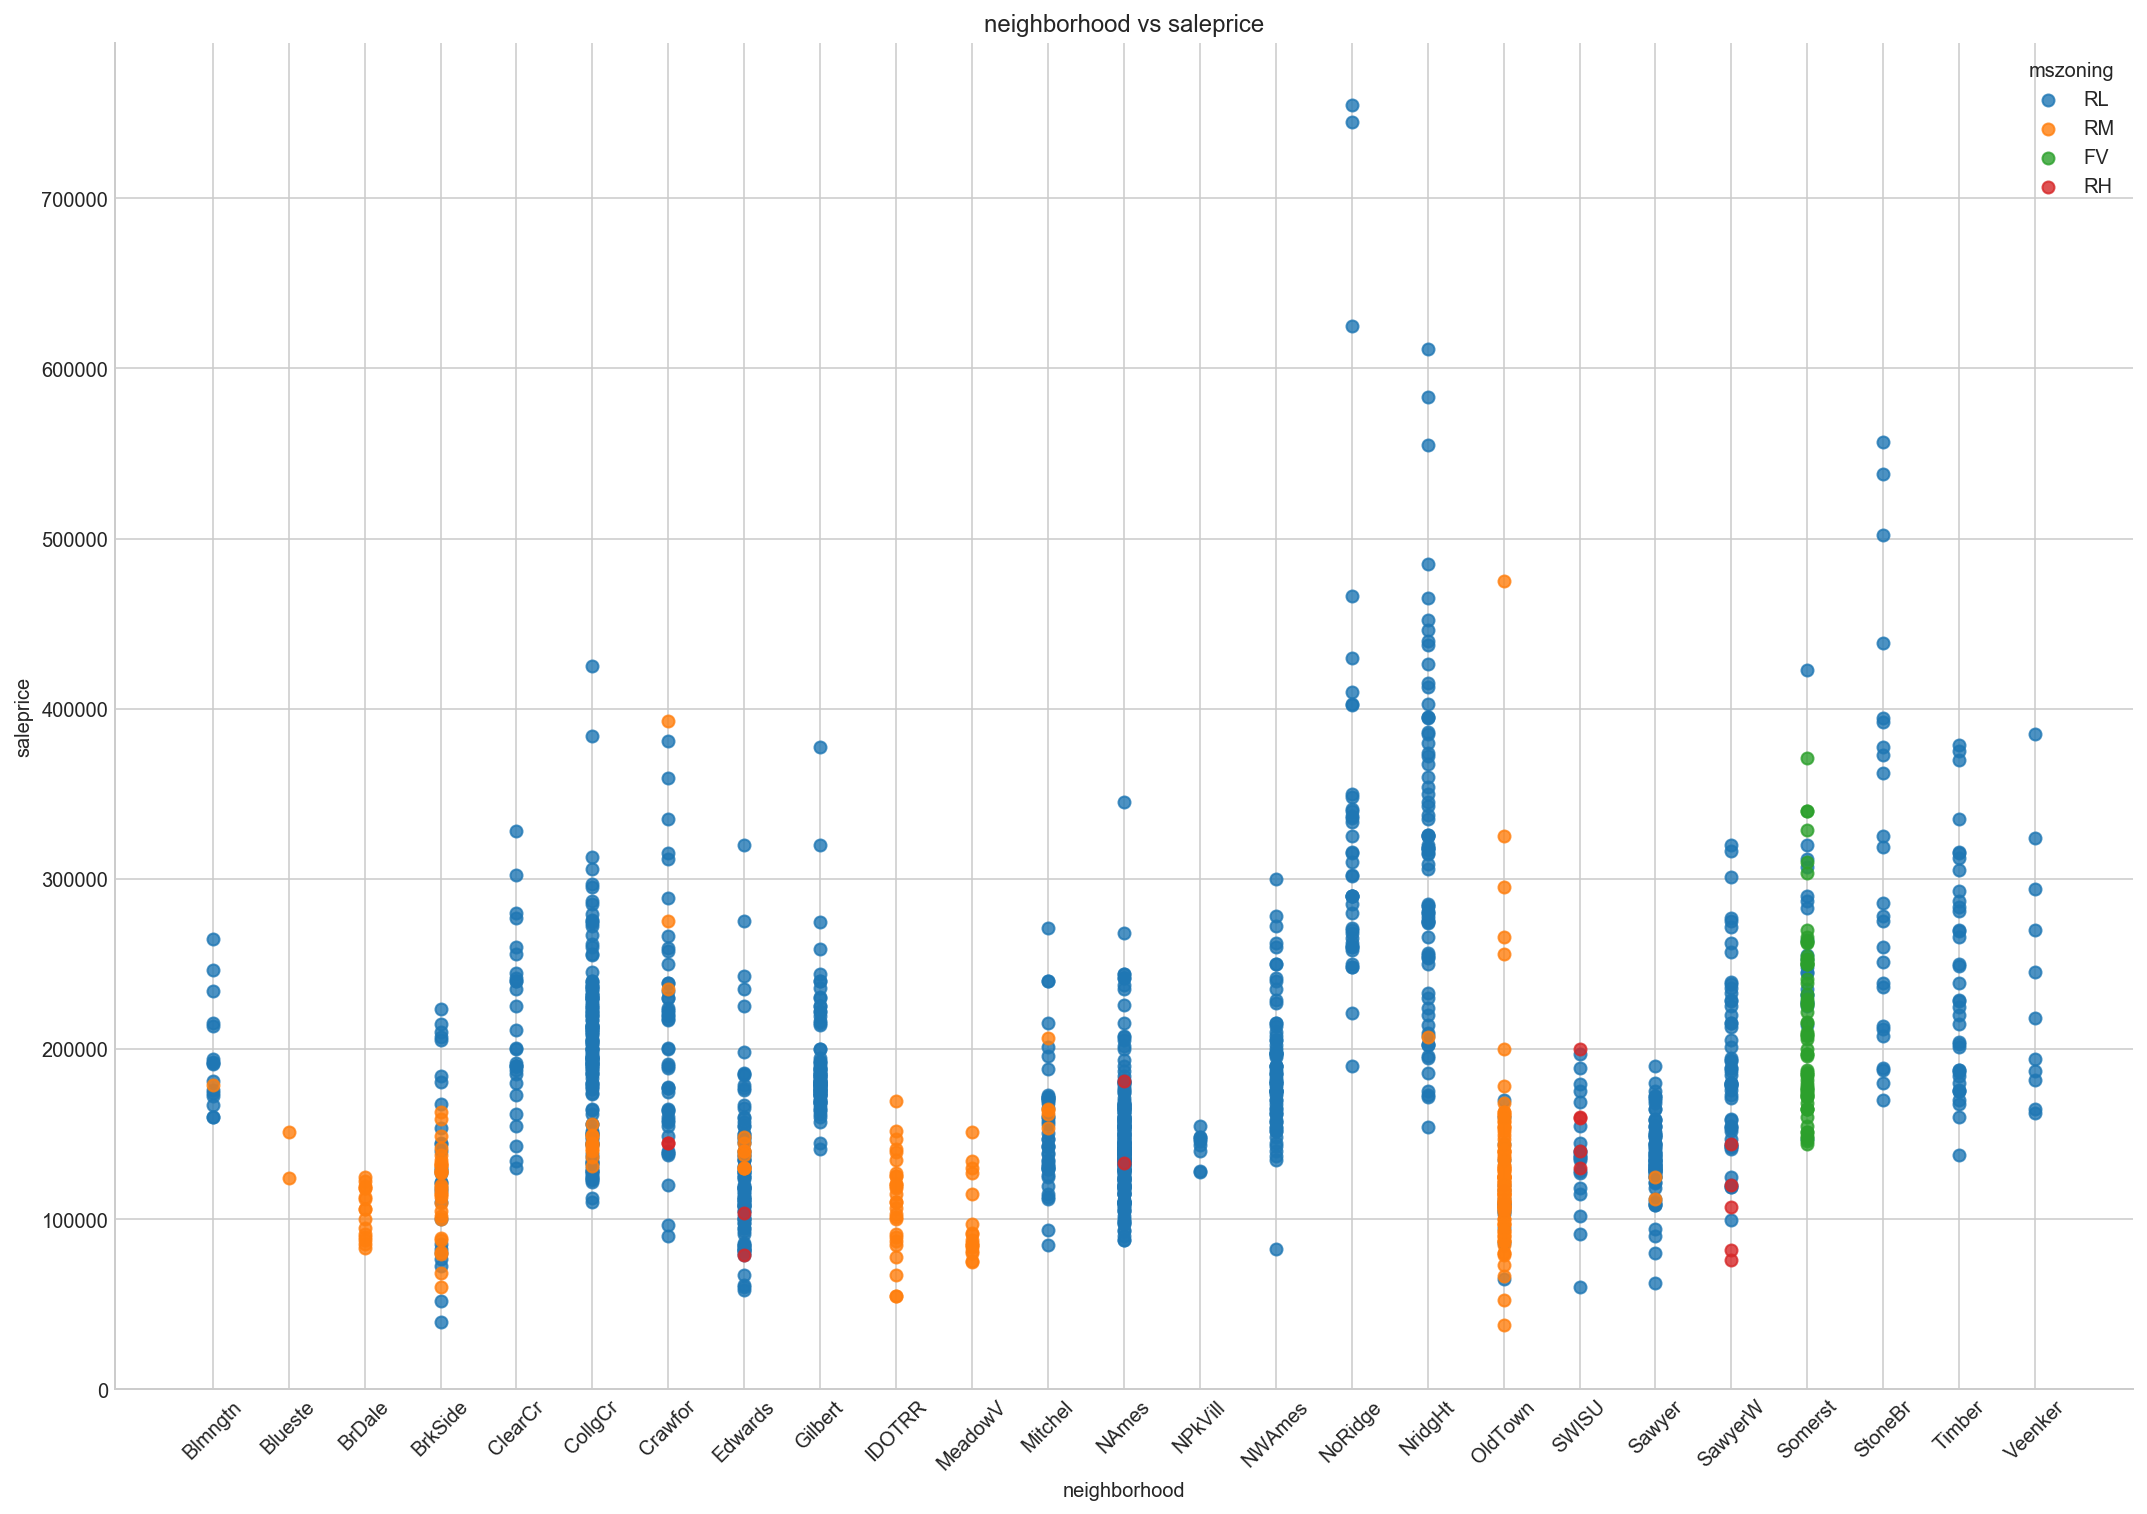

In [21]:
x='neighborhood'
y='saleprice'
lm = sns.lmplot(x=x,y=y,data=residential,hue='mszoning',
                fit_reg=False,size=10,aspect=1.5,legend_out=False)

plt.title('{} vs {}'.format(x,y))
plt.xticks(rotation=45)
plt.ylim(0,)
plt.show()

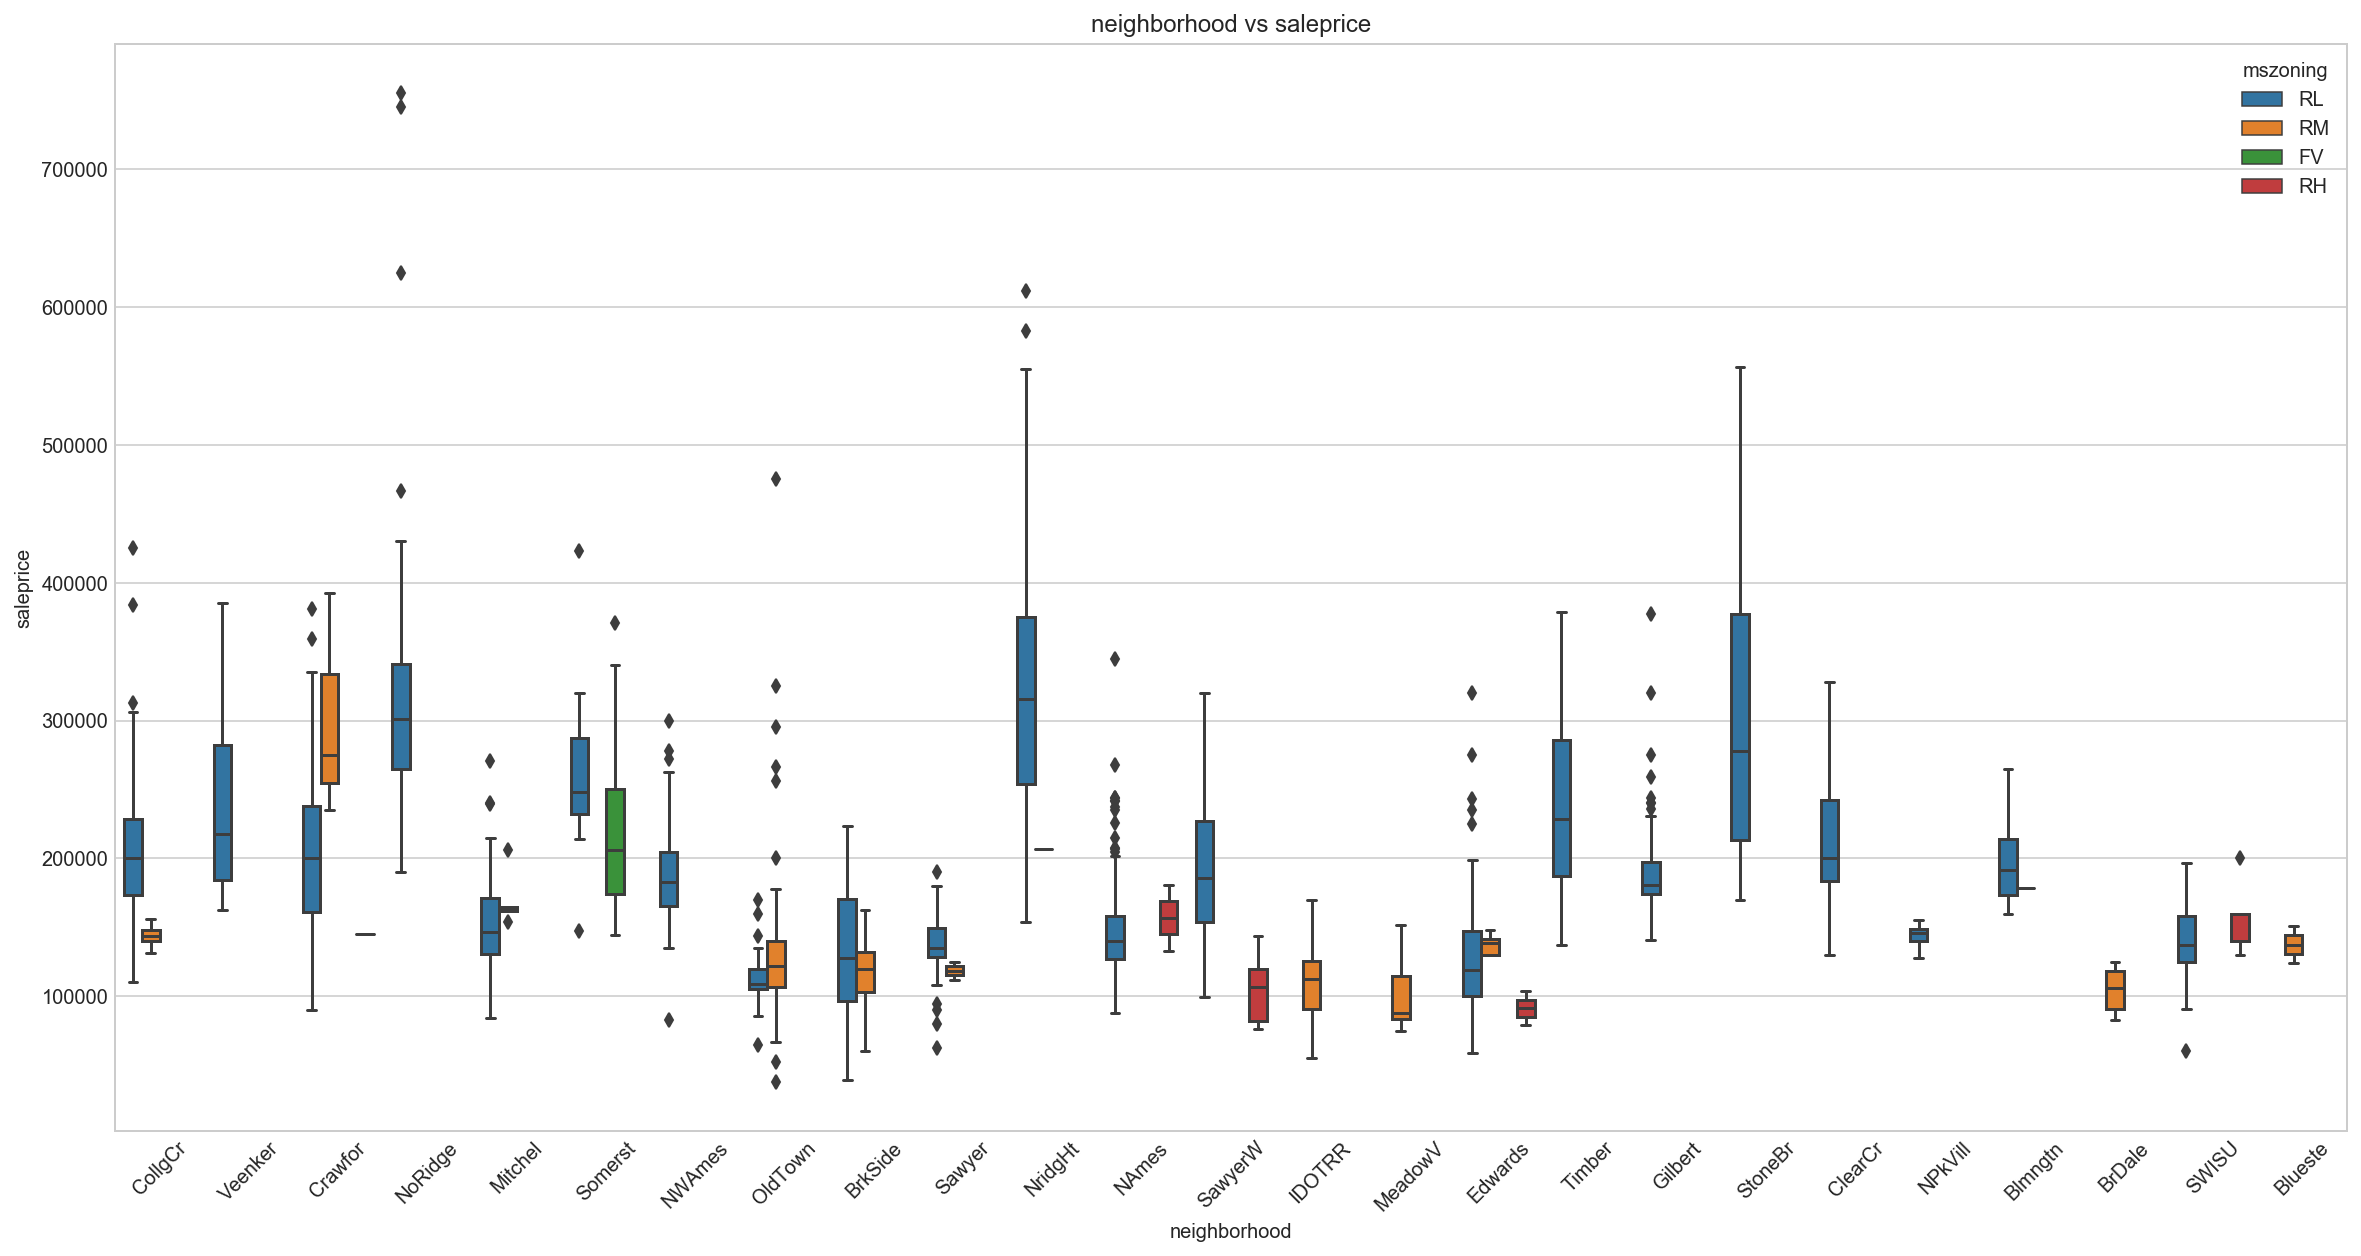

In [22]:
plt.figure(figsize=(20,10))

x='neighborhood'
y='saleprice'
sns.boxplot(x=x,y=y,data=residential,hue='mszoning')

# plt.ylim(0,25000)
plt.title('{} vs {}'.format(x,y))
plt.xticks(rotation=45)
plt.show()

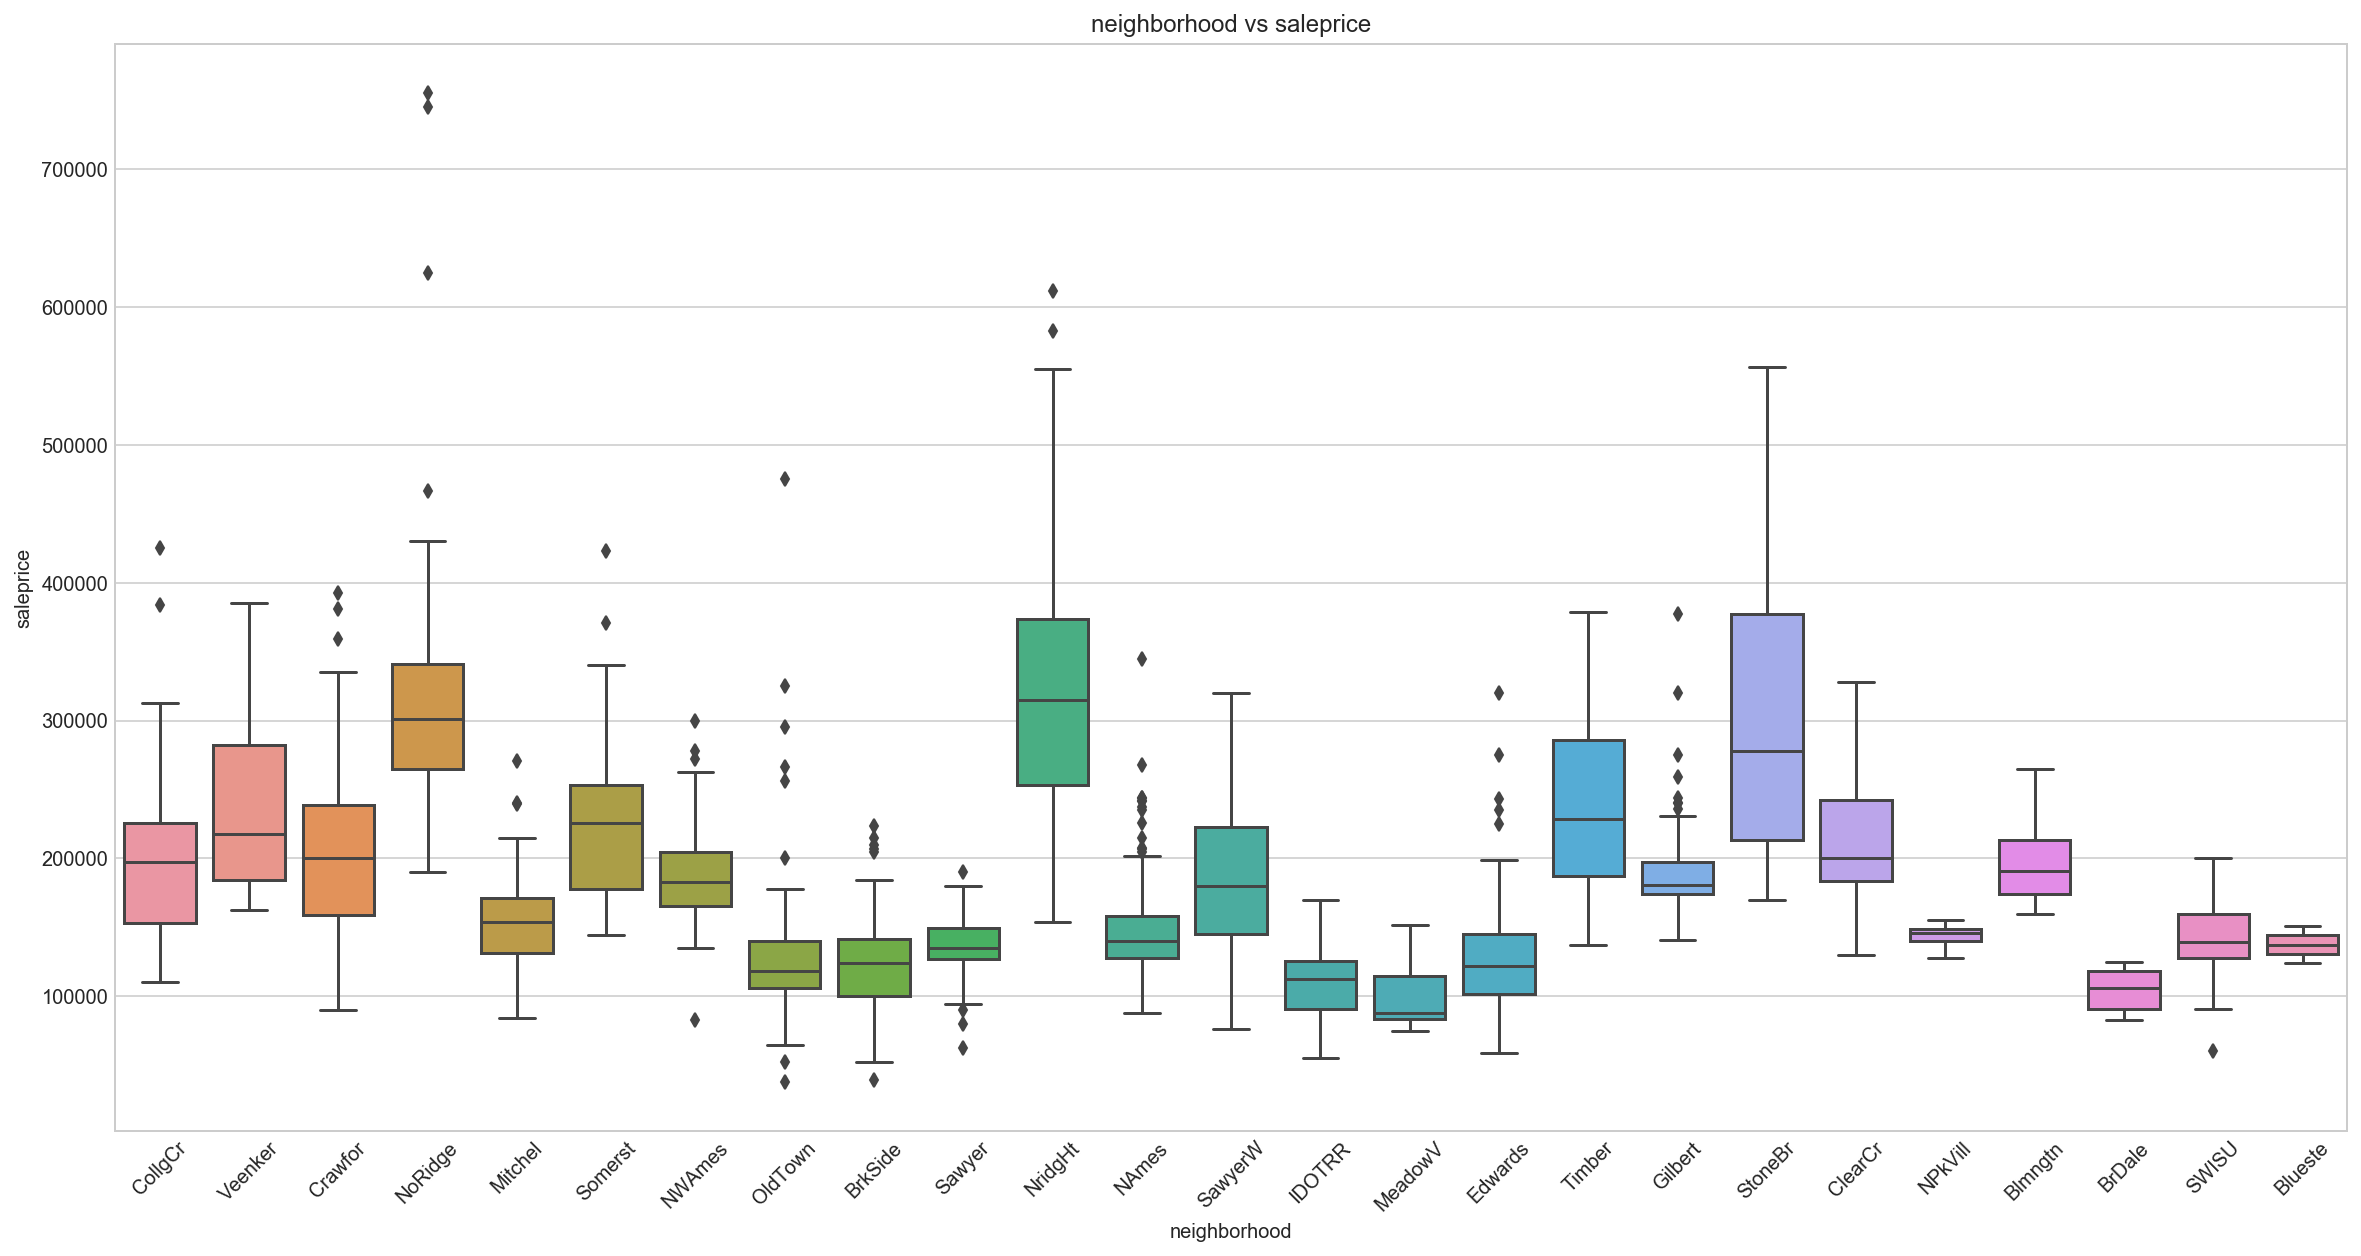

In [23]:
plt.figure(figsize=(20,10))

x='neighborhood'
y='saleprice'
sns.boxplot(x=x,y=y,data=residential)

# ,hue='garagecars'

# plt.ylim(0,25000)
plt.title('{} vs {}'.format(x,y))
plt.xticks(rotation=45)
plt.show()

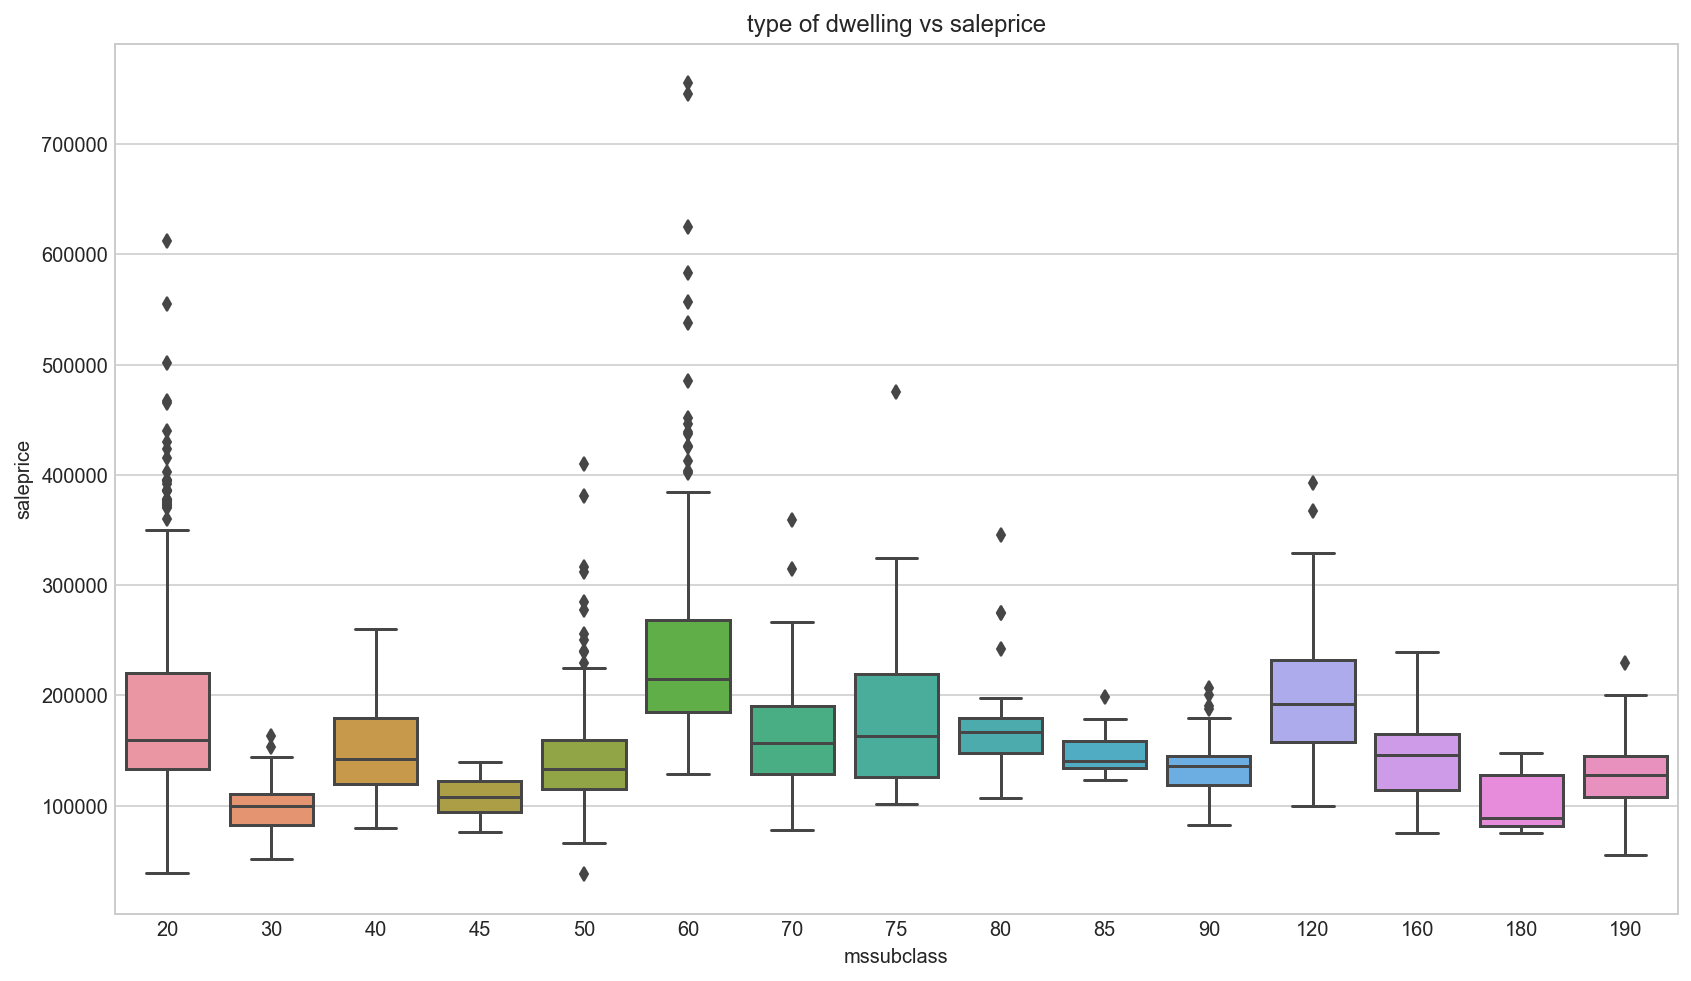

In [24]:

plt.figure(figsize=(14,8))

x='mssubclass'
y='saleprice'
sns.boxplot(x=x,y=y,data=residential)

# plt.ylim(0,500000)
plt.title('type of dwelling vs {}'.format(y))
plt.show()

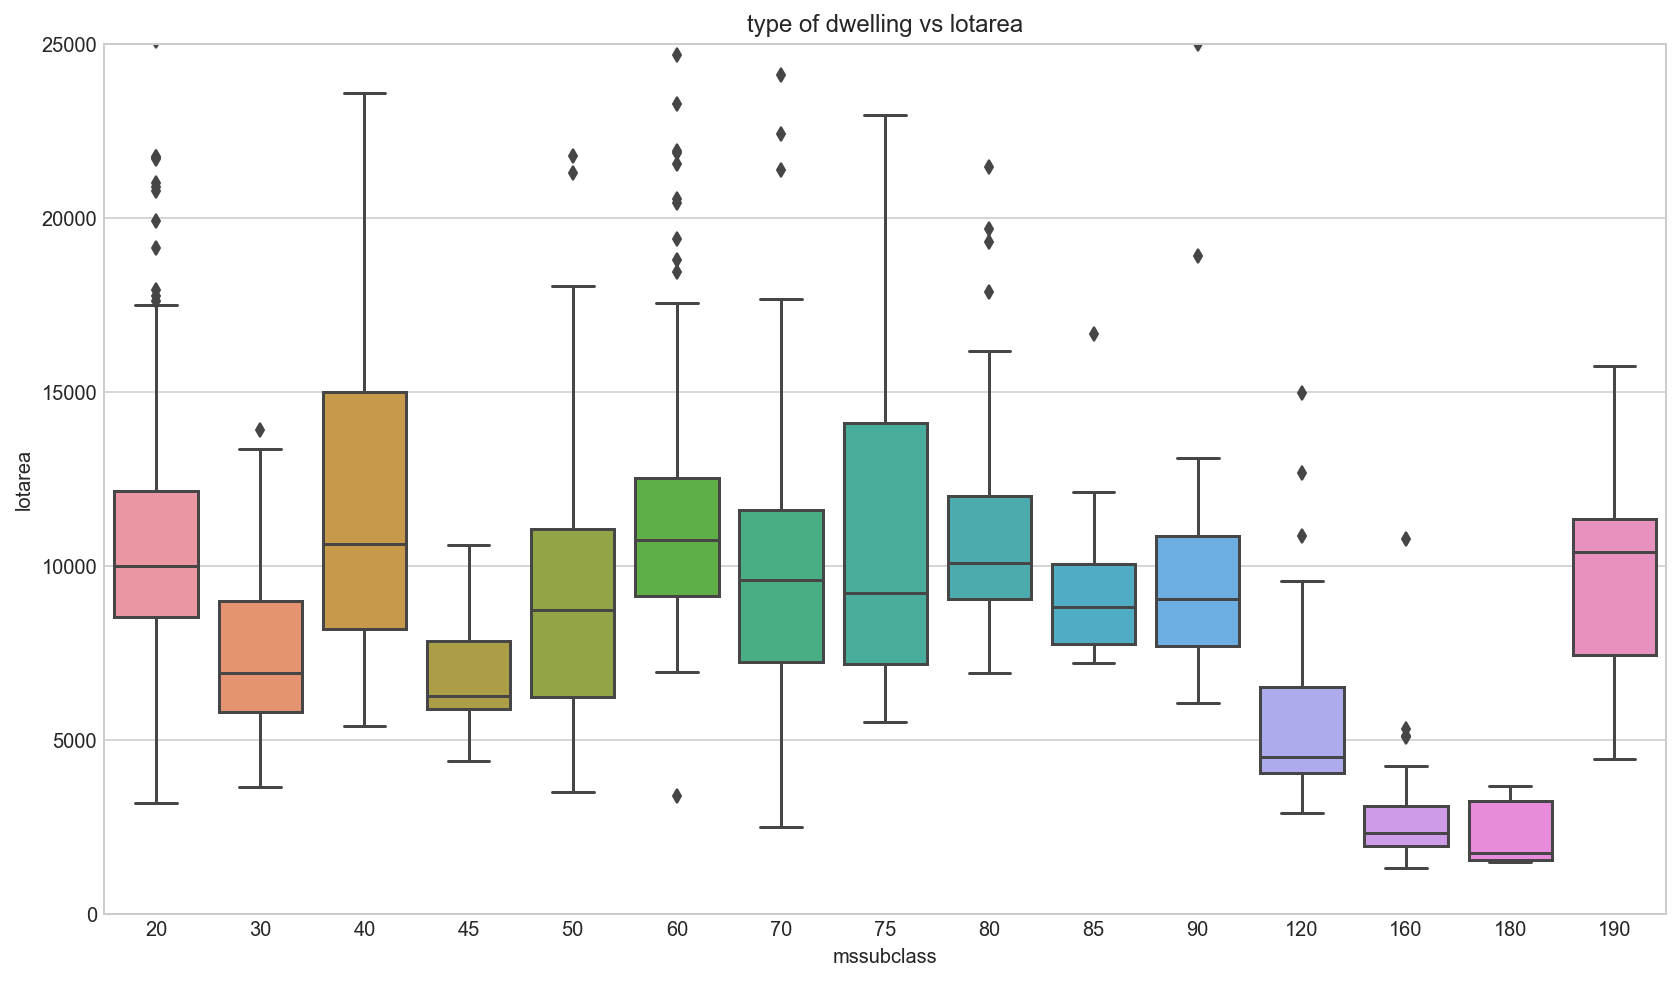

In [25]:
plt.figure(figsize=(14,8))

x='mssubclass'
y='lotarea'
sns.boxplot(x=x,y=y,data=residential)

plt.ylim(0,25000)
plt.title('type of dwelling vs {}'.format(y))
plt.show()

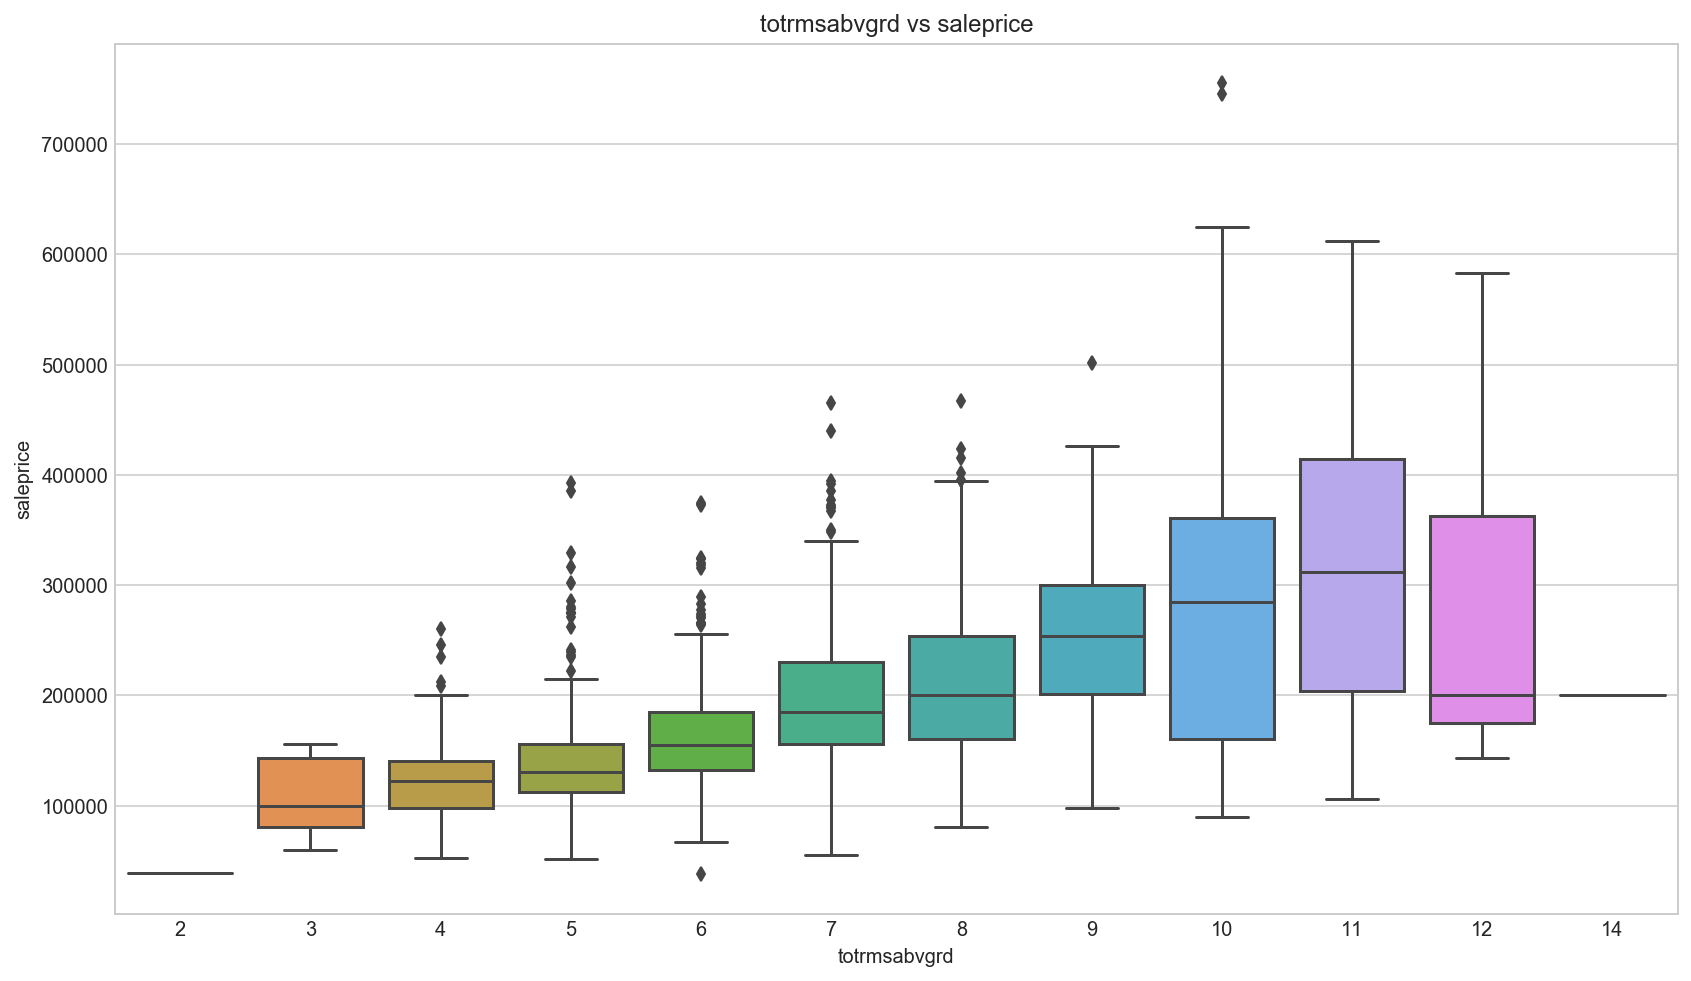

In [26]:
plt.figure(figsize=(14,8))

x='totrmsabvgrd'
y='saleprice'
sns.boxplot(x=x,y=y,data=residential)

# plt.ylim(0,25000)
plt.title('{} vs {}'.format(x,y))
plt.xticks()
plt.show()

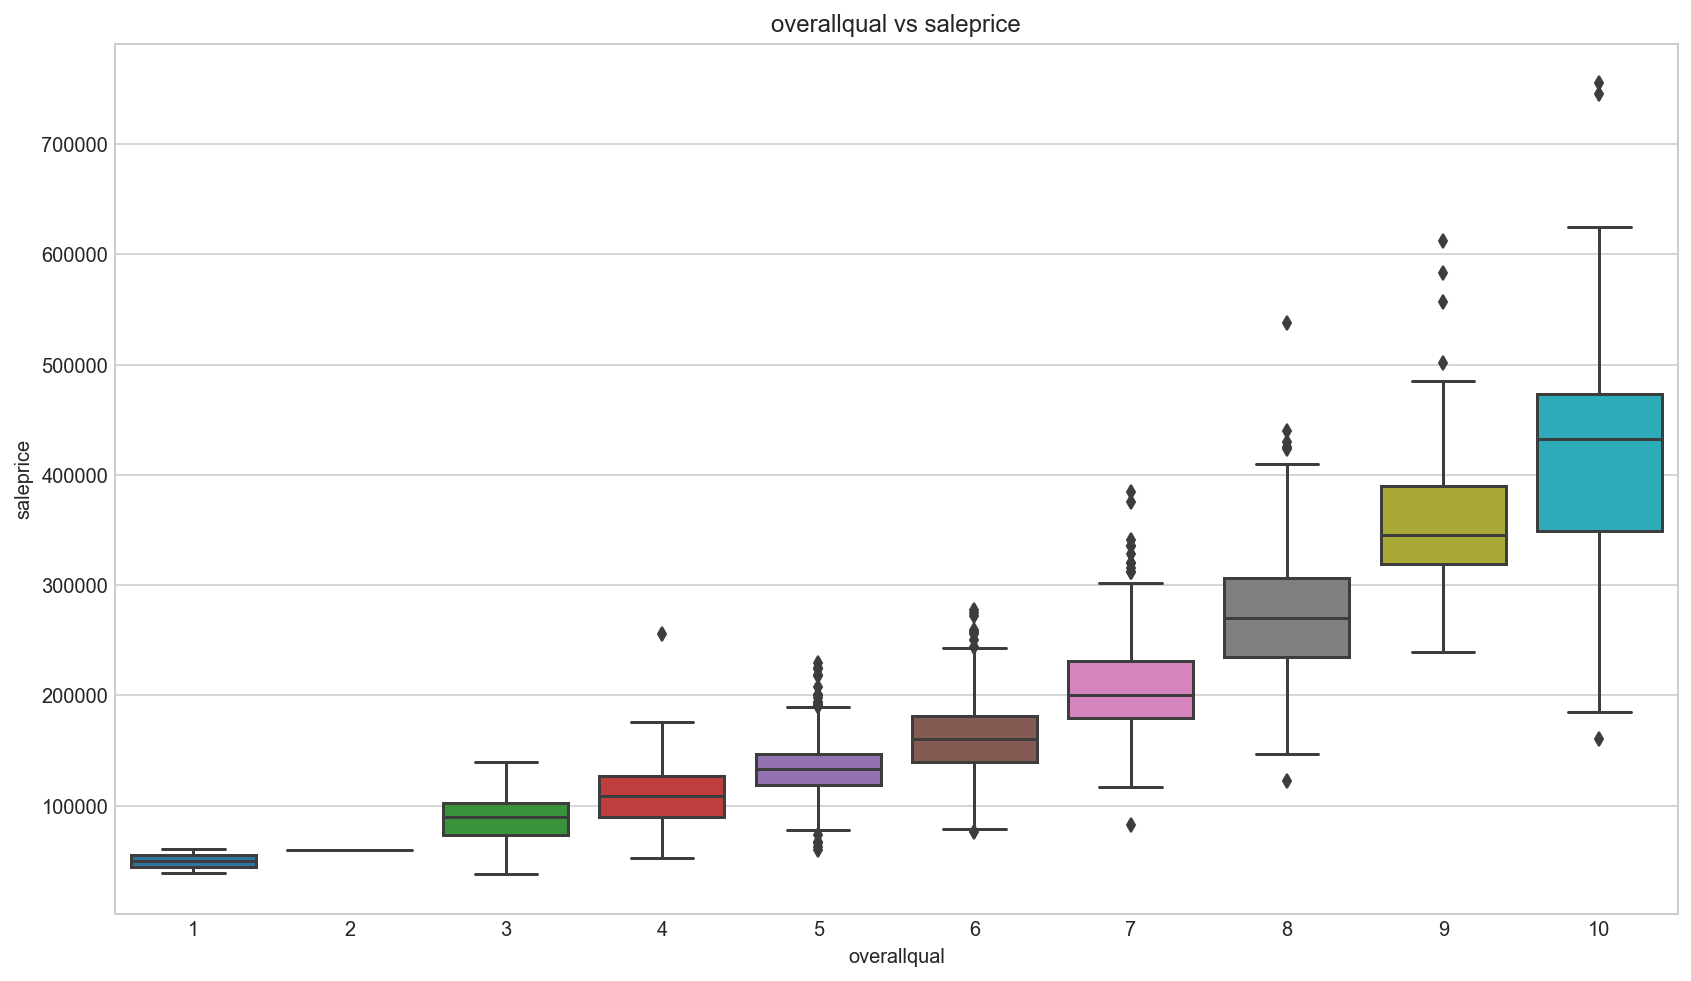

In [27]:
plt.figure(figsize=(14,8))

x='overallqual'
y='saleprice'
sns.boxplot(x=x,y=y,data=residential)

# plt.ylim(0,25000)
plt.title('{} vs {}'.format(x,y))
plt.xticks()
plt.show()

### Feature Engineering
Select only features that cannot be renovated

In [28]:
# for reference: all fixed feature attributes:
# fixed_feature = ['mssubclass','mszoning','lotarea','lotfrontage','street','alley','lotshape','landcontour','lotconfig',
#              'landslope','neighborhood','condition1','condition2','bldgtype','housestyle',
#              'yearbuilt','foundation','garagetype','paveddrive','bsmtfinsf1','bsmtfinsf2',
#              'bsmtunfsf','totalbsmtsf','1stflrsf','2ndflrsf','lowqualfinsf','grlivarea','bsmtfullbath',
#              'bsmthalfbath','fullbath','halfbath','bedroomabvgr', 'kitchenabvgr','totrmsabvgrd','fireplaces',
#              'garageyrblt','garagecars','garagearea','wooddecksf','openporchsf','enclosedporch','3ssnporch',
#              'poolarea','miscfeature']

In [29]:
# convert int to str for dummy variable conversion:
residential.mssubclass = residential.mssubclass.astype(str)
residential.garagecars = residential.garagecars.astype(str)

In [30]:
# based on corr heatmap remove attributes that are less than 0.5: 
# continuous variable fixed feature attributes:
cont_var_ff = ['lotarea','lotfrontage','yearbuilt',
             'totalbsmtsf','1stflrsf','2ndflrsf','grlivarea','bsmtfullbath',
             'fullbath','halfbath','bedroomabvgr','totrmsabvgrd','fireplaces',
             'garageyrblt','garagearea']

# discrete variable fixed feature attributes:
discrete_var_ff = ['mszoning','street','alley','lotshape','landcontour','lotconfig','landslope',
             'neighborhood','condition1','condition2','bldgtype','housestyle','foundation','garagetype',
             'paveddrive','garagecars','miscfeature']

# binarised discrete var ff attributes:
residential_binary = pd.get_dummies(residential[discrete_var_ff],dummy_na=True,drop_first=True)

In [31]:
# concat both cont. and discrete:
residential_ff = pd.concat([residential[cont_var_ff],residential_binary],axis=1)

# garageblt have 81 null value. replace all null values with 0:
residential_ff.fillna(0,inplace=True)

### Feature selection
#### Using f_classif:

In [32]:
X = residential_ff
y = residential.saleprice

ss = StandardScaler()
Xss = ss.fit_transform(X)
mm = MinMaxScaler()
Xmm = mm.fit_transform(X)

In [33]:
skb_f = SelectKBest(f_classif, k=5)
skb_f.fit(Xss,y)
f_results = pd.DataFrame([residential_ff.columns, list(skb_f.scores_), list(skb_f.get_support()), 
                        list(skb_f.pvalues_)], 
                       index=['feature','f_score','f_support','f_pvalues']).T.sort_values('f_score', ascending=False)

/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 18  20  26  30  35  38  63  72  78  80  85  93  99 108 113] are constant.
  UserWarning)
/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/anaconda2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [34]:
f_results.head(26)

,feature,f_score,f_support,f_pvalues
78,condition2_RRAn,inf,True,0
111,garagecars_3,4.58155,True,8.21669e-89
54,neighborhood_NridgHt,4.49939,True,6.8753e-87
76,condition2_PosN,3.61985,True,3.60576e-65
6,grlivarea,3.47663,True,1.95651e-61
53,neighborhood_NoRidge,3.44527,False,1.30752e-60
0,lotarea,3.30943,False,5.22819e-57
14,garagearea,2.74288,False,1.54991e-41
62,neighborhood_Veenker,2.7012,False,2.24524e-40
8,fullbath,2.65889,False,3.40169e-39


#### Using chi2 method:

In [35]:
mm = MinMaxScaler()
Xmm = mm.fit_transform(X)
y = residential.saleprice

skb_chi = SelectKBest(chi2,k=5)
skb_chi.fit(Xmm,y)
chi_results = pd.DataFrame([residential_ff.columns, list(skb_chi.scores_), list(skb_chi.get_support()), 
                        list(skb_chi.pvalues_)], 
                       index=['feature','chi_score','chi_support','chi_pvalues']).T.sort_values('chi_score', ascending=False)

In [36]:
chi_results.head(115)

,feature,chi_score,chi_support,chi_pvalues
78,condition2_RRAn,1449,True,8.84543e-62
76,condition2_PosN,1085.5,True,9.98153e-24
54,neighborhood_NridgHt,1082.24,True,1.91465e-23
53,neighborhood_NoRidge,1043.03,True,3.80558e-20
111,garagecars_3,1004.87,True,3.99836e-17
62,neighborhood_Veenker,994.114,False,2.61536e-16
24,lotshape_IR3,983.423,False,1.63076e-15
96,foundation_Slab,922.096,False,2.78029e-11
88,housestyle_2.5Fin,875.594,False,1.77879e-08
59,neighborhood_Somerst,868.59,False,4.36762e-08


#### Using RFECV method:

In [37]:
X = residential_ff
y = residential.saleprice

ss = StandardScaler()
Xss = ss.fit_transform(X)

import time
start = time.time()

lr = LinearRegression()
selector = RFECV(lr,step=1,n_jobs=-1,verbose=1,cv=10)
selector = selector.fit(Xss,y)

end = time.time()
end-start

Fitting estimator with 118 features.
Fitting estimator with 118 features.
Fitting estimator with 118 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 117 features.
Fitting estimator with 117 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 116 features.
Fitting estimator with 116 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 115 features.
Fitting estimator with 115 features.
Fitting estimator with 113 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 114 features.
Fitting estimator with 112 features.
Fitting estimator with 113 features.
Fitting estimator with 111 features.
Fitting estimator with 112 features.
Fitting estimator with 110 features.
Fitting estimator with 114 features.
F

Fitting estimator with 56 features.
Fitting estimator with 65 features.
Fitting estimator with 55 features.
Fitting estimator with 55 features.
Fitting estimator with 64 features.
Fitting estimator with 54 features.
Fitting estimator with 70 features.
Fitting estimator with 63 features.
Fitting estimator with 53 features.
Fitting estimator with 62 features.
Fitting estimator with 54 features.
Fitting estimator with 69 features.
Fitting estimator with 52 features.
Fitting estimator with 61 features.
Fitting estimator with 68 features.
Fitting estimator with 53 features.
Fitting estimator with 60 features.
Fitting estimator with 51 features.
Fitting estimator with 67 features.
Fitting estimator with 59 features.
Fitting estimator with 66 features.
Fitting estimator with 58 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 52 fe

Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 118 features.
Fitting estimator with 113 features.
Fitting estimator with 24 features.
Fitting estimator with 112 features.
Fitting estimator with 23 features.
Fitting estimator with 112 features.
Fitting estimator with 117 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 111 features.
Fitting estimator with 18 features.
Fitting estimator with 116 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6

Fitting estimator with 61 features.
Fitting estimator with 75 features.
Fitting estimator with 64 features.
Fitting estimator with 60 features.
Fitting estimator with 60 features.
Fitting estimator with 74 features.
Fitting estimator with 59 features.
Fitting estimator with 59 features.
Fitting estimator with 63 features.
Fitting estimator with 58 features.
Fitting estimator with 73 features.
Fitting estimator with 58 features.
Fitting estimator with 62 features.
Fitting estimator with 57 features.
Fitting estimator with 61 features.
Fitting estimator with 72 features.
Fitting estimator with 56 features.
Fitting estimator with 60 features.
Fitting estimator with 71 features.
Fitting estimator with 59 features.
Fitting estimator with 57 features.
Fitting estimator with 55 features.
Fitting estimator with 70 features.
Fitting estimator with 54 features.
Fitting estimator with 58 features.
Fitting estimator with 56 features.
Fitting estimator with 69 features.
Fitting estimator with 57 fe

Fitting estimator with 9 features.
Fitting estimator with 22 features.
Fitting estimator with 118 features.
Fitting estimator with 21 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 20 features.
Fitting estimator with 5 features.
Fitting estimator with 117 features.
Fitting estimator with 19 features.
Fitting estimator with 4 features.
Fitting estimator with 117 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 18 features.
Fitting estimator with 116 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 115 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 116 features.
Fitting estimator with 13 features.
Fitting estimator with 114 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 fea

Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 14 features.
Fitting estimator with 20 features.
Fitting estimator with 13 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 12 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 11 features.
Fitting estimator with 15 features.
Fitting estimator with 10 features.
Fitting estimator with 14 features.
Fitting estimator with 9 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 8 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 7 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 7 features.
F

11.274394989013672

In [38]:
rfecv_results = pd.DataFrame([X.columns,selector.support_,selector.ranking_],index=['feature','support','ranking']).T.sort_values('ranking')
rfecv_features = rfecv_results.loc[rfecv_results['ranking']==1].copy()
rfecv_results.loc[rfecv_results['ranking']==1]

,feature,support,ranking
0,lotarea,True,1
104,garagetype_Detchd,True,1
76,condition2_PosN,True,1
36,landslope_Mod,True,1
37,landslope_Sev,True,1
102,garagetype_BuiltIn,True,1
101,garagetype_Basment,True,1
100,garagetype_Attchd,True,1
95,foundation_PConc,True,1
92,housestyle_SLvl,True,1


### Prediction model

In [39]:
# split train and test set using yrsold
residential_ff = residential_ff.join(residential['yrsold'])
test_df = residential_ff.loc[residential_ff['yrsold']==2010].copy()
train_df = residential_ff.loc[residential_ff['yrsold']<2010].copy()

#### Linear Regression with no feature elimination done (using all 139 columns):

In [40]:
X = train_df
y = residential.loc[residential['yrsold']<2010]['saleprice'].copy()
# check shape of X and y:
X.shape,y.shape

((1278, 119), (1278,))

In [41]:
# Standardise all variables 
ss = StandardScaler()
Xs = ss.fit_transform(X)
kfold = KFold(n_splits=3,random_state=44)
lr = LinearRegression()
accuracy_train4 = cross_val_score(lr,Xs,y,cv=kfold)
print (np.mean(accuracy_train4))

-3.089349100648841e+24


### Validation of f_classif method:
<br>1. run through all features from training dataset to fit into linear regression model to find optimal no. of features
<br>2. predict sale price (y_pred) using training dataset
<br>3. print accuracy score (fingers crossed)

In [42]:
accuracy_lst1 = []
accuracy_lst2 = []
for x in range(1,len(f_results)+1):
    top_f = f_results[:x].feature
    X2 = train_df[top_f]
    y2 = residential.loc[residential['yrsold']<2010]['saleprice'].copy()
    
    ss = StandardScaler()
    Xs = ss.fit_transform(X2)
    kfold = KFold(n_splits=3,random_state=44)
    lr = LinearRegression()
    accuracy_train = cross_val_score(lr,Xs,y2,cv=kfold)
    
    accuracy_lst1.append(x)
    accuracy_lst2.append(np.mean(accuracy_train))
    
accuracy_df1 = pd.DataFrame ([accuracy_lst1,accuracy_lst2],index=['no_of_features','accuracy_score']).T

(0, 1)

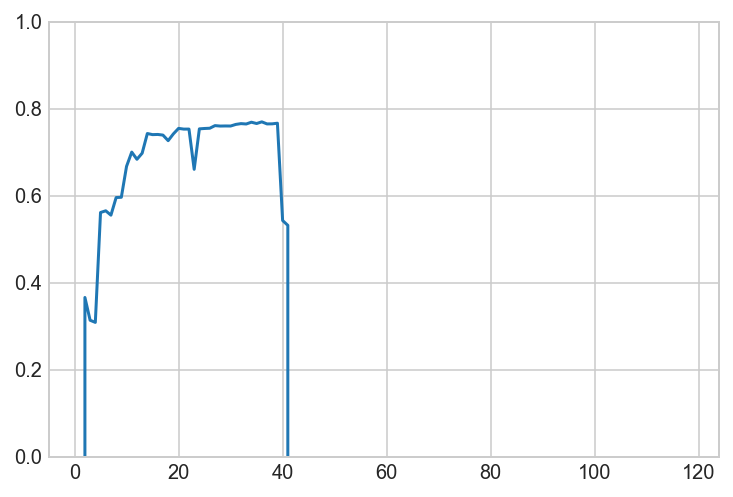

In [43]:
x=accuracy_df1['no_of_features']
y=accuracy_df1['accuracy_score']
plt.plot(x,y)
plt.ylim(0,1)

In [44]:
accuracy_df1.describe()

,no_of_features,accuracy_score
count,118.000000,1.180000e+02
mean,59.500000,-1.045967e+26
std,34.207699,3.566204e+26
min,1.000000,-2.416022e+27
25%,30.250000,-4.840590e+24
50%,59.500000,-6.244911e+23
75%,88.750000,6.445033e-01
max,118.000000,7.697458e-01


In [45]:
accuracy_df1.loc[accuracy_df1['accuracy_score']>0.76974]

,no_of_features,accuracy_score
35,36.0,0.769746


#### Linear Regression using f_classif method, choosing top 36 of features:

In [46]:
top_n = f_results[:36+1].feature
train_X = train_df[top_n]
train_y = residential.loc[residential['yrsold']<2010]['saleprice'].copy()
test_X = test_df[top_n]
test_y = residential.loc[residential['yrsold']==2010]['saleprice'].copy()

In [47]:
lr.fit(train_X,train_y)
y_pred = lr.predict(test_X)
print (r2_score(test_y,y_pred))

0.8277624221180925


### Validation of chi2 method:
<br>1. run through all features from training dataset to fit into linear regression model to find optimal no. of features
<br>2. predict sale price (y_pred) using training dataset
<br>3. print accuracy score (fingers crossed)

In [48]:
accuracy_lst3 = []
accuracy_lst4 = []
for x in range(1,len(chi_results)+1):
    top_chi = chi_results[:x].feature
    X3 = train_df[top_chi]
    y3 = residential.loc[residential['yrsold']<2010]['saleprice'].copy()
    
    ss = StandardScaler()
    Xss = ss.fit_transform(X2)
    kfold = KFold(n_splits=3,random_state=44)
    lr = LinearRegression()
    accuracy_train2 = cross_val_score(lr,X3,y3,cv=kfold)
    
    accuracy_lst3.append(x)
    accuracy_lst4.append(np.mean(accuracy_train2))
    
accuracy_df2 = pd.DataFrame ([accuracy_lst3,accuracy_lst4],index=['no_of_features','accuracy_score']).T

(0, 1)

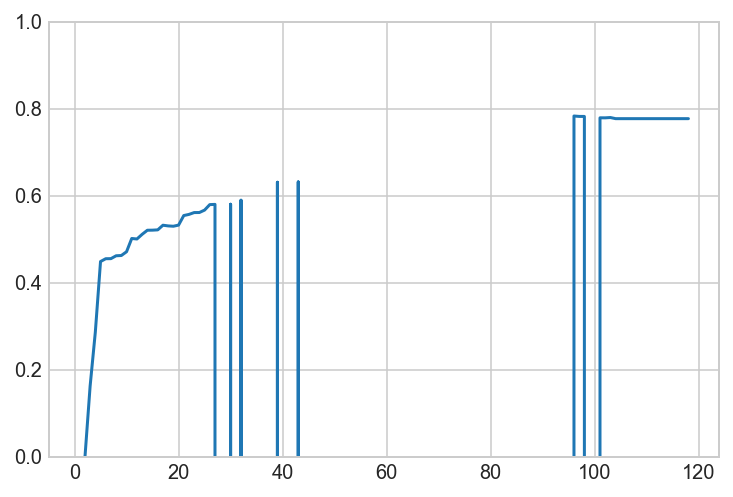

In [49]:
x=accuracy_df2['no_of_features']
y=accuracy_df2['accuracy_score']
plt.plot(x,y)
plt.ylim(0,1)

In [50]:
accuracy_df2.describe()

,no_of_features,accuracy_score
count,118.000000,1.180000e+02
mean,59.500000,-6.521209e+22
std,34.207699,1.297980e+23
min,1.000000,-5.477256e+23
25%,30.250000,-4.975427e+22
50%,59.500000,-1.629160e+15
75%,88.750000,5.600929e-01
max,118.000000,7.831708e-01


In [51]:
accuracy_df2.loc[accuracy_df2['accuracy_score']>0.7831708]

,no_of_features,accuracy_score
95,96.0,0.783171


#### Linear Regression using chi2 method, choosing 96 features:

In [52]:
top_n = chi_results[:96+1].feature
train_X = train_df[top_n]
train_y = residential.loc[residential['yrsold']<2010]['saleprice'].copy()
test_X = test_df[top_n]
test_y = residential.loc[residential['yrsold']==2010]['saleprice'].copy()

In [53]:
lr.fit(train_X,train_y)
y_pred = lr.predict(test_X)
print (r2_score(test_y,y_pred))

0.8544073502176193


In [54]:
top_feature_x = residential_ff[top_n]
entire_y_pred = lr.predict(top_feature_x)

#### Linear Regression using REFCV 58 selected fatures

In [55]:
top_n = rfecv_features.feature
train_X = train_df[top_n]
train_y = residential.loc[residential['yrsold']<2010]['saleprice'].copy()
test_X = test_df[top_n]
test_y = residential.loc[residential['yrsold']==2010]['saleprice'].copy()

In [56]:
lr.fit(train_X,train_y)
y_pred = lr.predict(test_X)
print (r2_score(test_y,y_pred))

0.86561859447


#### Linear Regression using ElasticNetCV

In [78]:
X = train_df
y = residential.loc[residential['yrsold']<2010]['saleprice'].copy()
ss = StandardScaler()
Xss = ss.fit_transform(X)

In [96]:
l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,)
optimal_enet.fit(Xss, y)

print ('Optimal alpha: {}'.format(optimal_enet.alpha_))
print ('Optimal l1 ratio: {}'.format(optimal_enet.l1_ratio_))

Optimal alpha: 978.5128945537086
Optimal l1 ratio: 1.0


In [97]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet_scores = cross_val_score(enet, Xss, y, cv=10)
enet.fit(X,y)
y_pred = enet.predict(test_df)

print ('Training accuracy score: {}'.format(np.mean(enet_scores)))
print ('Test accuracy score: {}'.format(r2_score(test_y,y_pred)))

Training accuracy score: 0.7866531688977145
Test accuracy score: 0.8261141610527358


#### Linear Regression using LassoCv

In [99]:
# find out optimal lasso in order to eliminate variables from All fixed features variable
optimal_lasso = LassoCV(n_alphas=500, cv=10)
optimal_lasso.fit(Xss, y)

print ('Optimal alpha: {}'.format(optimal_lasso.alpha_))

Optimal alpha: 969.6595174421439


In [98]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xs, y, cv=10)
lasso.fit(X,y)
y_pred = lasso.predict(test_df)

print ('Training accuracy score: {}'.format(np.mean(lasso_scores)))
print ('Test accuracy score: {}'.format(r2_score(test_y,y_pred)))

Training accuracy score: 0.7396272878378858
Test accuracy score: 0.8264013039606838


#### Shaun's comment:
##### Which algorithm is better tested against predicted values?
Chi2 score: 0.85; with 96 features <br>
f_classif score: 0.83; with 36 features <br>
RFECV score: 0.87 with 58 features <br>
Lasso score: 0.83<br>
ElasticNet: 0.83


##### What fixed characteristics that affects pricing of house?

Looking at the top 25 features, the following fixed characteristics will affect the pricing of house:<br>
-neighbourhood<br>
-condition2<br>
-garage conditions (type of garage, how many cars can the garage accomodate)<br>


In [61]:
conditions = chi_results.merge(f_results,how='left', on='feature')
# conditions = conditions.merge(rfecv_results,how='left',on='feature')
conditions.loc[conditions['chi_pvalues']<0.05]

,feature,chi_score,chi_support,chi_pvalues,f_score,f_support,f_pvalues
0,condition2_RRAn,1449,True,8.84543e-62,inf,True,0
1,condition2_PosN,1085.5,True,9.98153e-24,3.61985,True,3.60576e-65
2,neighborhood_NridgHt,1082.24,True,1.91465e-23,4.49939,True,6.8753e-87
3,neighborhood_NoRidge,1043.03,True,3.80558e-20,3.44527,False,1.30752e-60
4,garagecars_3,1004.87,True,3.99836e-17,4.58155,True,8.21669e-89
5,neighborhood_Veenker,994.114,False,2.61536e-16,2.7012,False,2.24524e-40
6,lotshape_IR3,983.423,False,1.63076e-15,2.60373,False,1.18471e-37
7,foundation_Slab,922.096,False,2.78029e-11,2.21207,False,1.07699e-26
8,housestyle_2.5Fin,875.594,False,1.77879e-08,1.86872,False,2.40474e-17
9,neighborhood_Somerst,868.59,False,4.36762e-08,2.11943,False,3.96578e-24


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [62]:
# convert int to str for dummy variable conversion:
residential.overallcond = residential.overallcond.astype(str)
residential.overallqual = residential.overallqual.astype(str)

In [63]:
# continuous variable fixed feature attributes:
cont_var_rf = ['yearremodadd', 'masvnrarea','bsmtfinsf1','bsmtfinsf2','bsmtunfsf','lowqualfinsf','wooddecksf','openporchsf',
               'enclosedporch','3ssnporch']

# discrete variable fixed feature attributes:
discrete_var_rf=['overallqual','overallcond','roofstyle','roofmatl','exterior1st','exterior2nd','masvnrtype','exterqual','extercond',
                'bsmtqual','bsmtcond','bsmtexposure','bsmtfintype1','bsmtfintype2','heating','heatingqc','centralair','electrical',
                 'kitchenqual','functional','fireplacequ','garagefinish','garagequal','garagecond','poolqc','fence']

# binarised discrete var ff attributes:
residential_binary = pd.get_dummies(residential[discrete_var_rf],dummy_na=True,drop_first=True)

In [64]:
# concat both cont. and discrete:
residential_rf = pd.concat([residential[cont_var_rf],residential_binary],axis=1)

# replace all null values with 0:
residential_rf.fillna(0,inplace=True)

In [65]:
entire_y_obs = residential.saleprice
y_residual = pd.DataFrame(entire_y_obs - entire_y_pred)
y_residual

,saleprice
0,4892.782268
1,4107.511172
2,3519.867451
3,-84606.255011
4,-71806.523063
5,-8022.170187
6,63178.549366
7,-28973.050051
8,-25236.035318
9,-17927.561332


### Feature selection
#### Using f_classif:

In [66]:
X = residential_rf
y = y_residual

ss = StandardScaler()
Xss = ss.fit_transform(X)
mm = MinMaxScaler()
Xmm = mm.fit_transform(X)

In [67]:
skb_f = SelectKBest(f_classif, k=5)
skb_f.fit(Xss,y)
f_results = pd.DataFrame([residential_rf.columns, list(skb_f.scores_), list(skb_f.get_support()), 
                        list(skb_f.pvalues_)], 
                       index=['feature','f_score','f_support','f_pvalues']).T.sort_values('f_score', ascending=False)

E:\Data Science Programs\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
E:\Data Science Programs\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 15

Based on StackOverflow:<br>
'It may be a bit late to answer. But this warning means that there are some features present in your data which have same value for all the samples in the data. It doesn't change for any class label or any row of your data. You can safely remove those features from the data because they dont take part in deciding the prediction label.'<br>
Out of 166 features, 164 features are not relevant to the prediction :'(

#### Using chi2 method: (Error encountered)

### Prediction model

In [68]:
# split train and test set using yrsold
residential_rf = residential_rf.join(residential['yrsold'])
test_df2 = residential_rf.loc[residential_rf['yrsold']==2010].copy()
train_df2 = residential_rf.loc[residential_rf['yrsold']<2010].copy()

#### Linear Regression with no feature elimination done (using all 166 columns):

In [69]:
X = train_df2
y = residential.loc[residential['yrsold']<2010]['saleprice'].copy()
# check shape of X and y:
X.shape,y.shape

((1278, 166), (1278,))

In [70]:
# Standardise all variables 
ss = StandardScaler()
Xs = ss.fit_transform(X)
kfold = KFold(n_splits=3,random_state=44)
lr = LinearRegression()
accuracy_train4 = cross_val_score(lr,Xs,y,cv=kfold)
print (np.mean(accuracy_train4))

-1.15953572635e+26


### Validation of f_classif method:
<br>Regardless of what the error said, I decided to go ahead and try fitting all 166 features to see at what no. of features will the model give me the highest accuracy score.

In [71]:
accuracy_lst1 = []
accuracy_lst2 = []
for x in range(1,len(f_results)+1):
    top_f = f_results[:x].feature
    X2 = train_df2[top_f]
    y2 = residential.loc[residential['yrsold']<2010]['saleprice'].copy()
    
    ss = StandardScaler()
    Xs = ss.fit_transform(X2)
    kfold = KFold(n_splits=3,random_state=44)
    lr = LinearRegression()
    accuracy_train = cross_val_score(lr,Xs,y2,cv=kfold)
    
    accuracy_lst1.append(x)
    accuracy_lst2.append(np.mean(accuracy_train))
    
accuracy_df1 = pd.DataFrame ([accuracy_lst1,accuracy_lst2],index=['no_of_features','accuracy_score']).T

(0, 1)

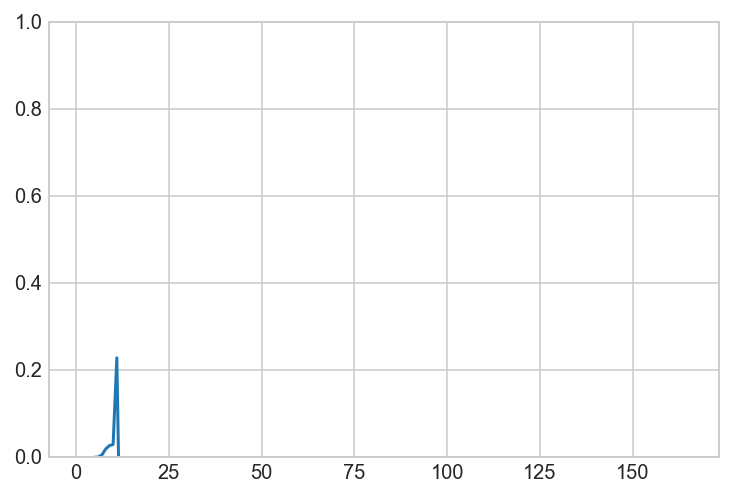

In [72]:
x=accuracy_df1['no_of_features']
y=accuracy_df1['accuracy_score']
plt.plot(x,y)
plt.ylim(0,1)

In [73]:
accuracy_df1.describe()

,no_of_features,accuracy_score
count,165.000000,1.650000e+02
mean,83.000000,-1.893931e+26
std,47.775517,2.264882e+26
min,1.000000,-1.938049e+27
25%,42.000000,-2.364784e+26
50%,83.000000,-1.205751e+26
75%,124.000000,-5.324577e+25
max,165.000000,2.271406e-01


In [74]:
accuracy_df1.loc[accuracy_df1['accuracy_score']>0.22714]

,no_of_features,accuracy_score
10,11.0,0.227141


#### Linear Regression using f_classif method, choosing 11 of features:

In [75]:
top_n = f_results[:11+1].feature
train_X = train_df2[top_n]
train_y = residential.loc[residential['yrsold']<2010]['saleprice'].copy()
test_X = test_df2[top_n]
test_y = residential.loc[residential['yrsold']==2010]['saleprice'].copy()

In [76]:
lr.fit(train_X,train_y)
y_pred = lr.predict(test_X)
print (r2_score(test_y,y_pred))

0.277180284257


<font size=7> ?! </font>

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
# A:

NameError: name 'X' is not defined